# Galloway-Math 7243 VIX Prediction Project Neural Net

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# get current directory
curr_dir = os.getcwd()
curr_dir

'C:\\Users\\josh.galloway\\Google Drive\\Synch\\Education\\_Northeastern University\\01_MATH 7243 Machine Learning 1\\Projects\\VIX Project'

### Helper Funcitons

In [204]:
'''Define training function'''
def trainModel(x_data_dict,y_data,model,init_weights_file,
               n_epoch,n_batch,n_valid,_callbacks = None):
    '''Train Model on Data and Return Hist'''
    histDict = {}
    for x_key in x_data_dict.keys():
        model.load_weights(init_weights_file)
        print('==========================\n',x_key)
        np.random.seed(42)
        hist = model.fit(x_data_dict[x_key], y_data,
                        validation_split=n_valid,
                        batch_size=n_batch,
                        epochs=n_epoch,
                        verbose=1,
                        callbacks = _callbacks) 
        histDict[x_key] = hist
    return histDict


from matplotlib import colors as mcolors
from itertools import cycle
COLORS = cycle(mcolors.TABLEAU_COLORS.items())
def plotTrainCurves(histdict,n_rows,n_cols,n_shape):
    '''Plot Training Curves'''
    f, axes = plt.subplots(n_rows,n_cols)
    f.set_size_inches(*n_shape)
    axes = axes.flatten()
    for i,key_ in enumerate(histdict):
        axes[i].plot(histdict[key_].history['loss'],color=next(COLORS)[1])
        axes[i].set_title(key_)
        axes[i].grid()
    plt.tight_layout()
    
def getSentArray(df_col):
    '''Parse Sentiment Array to np.array'''
    A = np.array([])
    vals = df_col.values
    s0 = df_col.values.shape[0]
    s1 = len(vals[0][1:-1].split(','))
    for row in vals:
        A = np.append(A,np.array(row[1:-1].split(','),dtype=float),axis=0)
    return A.reshape(s0,s1)

In [214]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.layers import LSTM,BatchNormalization,GRU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

def create_model(lstm=True,n_nodes=64,n_dropout=0.2,n_learning_rate=0.001,step_size=20):
    '''Build Tunable Model Function'''
    _optimizer = Adam(learning_rate=n_learning_rate)
    model = Sequential()
    if lstm:
        model.add(LSTM(n_nodes,input_shape=(step_size,3)))
    else:
        model.add(GRU(n_nodes,input_shape=(step_size,3)))
    model.add(Dropout(n_dropout))
    model.add(Dense(1,activation='elu',kernel_initializer='he_normal',use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.compile(loss='mean_squared_error', optimizer=_optimizer,metrics=['accuracy'])
    return model

import pickle
def save_object(obj, filename, save=False,addTime=False):
    if save:
        # save the results to disk
        if addTime:
            temp = filename.split('.')
            filename = temp[0] + datetime.now().strftime("%Y%m%d-%H%M%S")+'.' + temp[-1]
        pickle.dump(obj, open(filename, 'wb'))
        print("Saved File: ",filename)
        return obj
    else:
        return pickle.load(open(filename, 'rb'))

from IPython.display import Audio, display  
beepFile = os.path.join(curr_dir, 'saves','Pager Beeps-SoundBible.com-260751720.mp3')
def done():
    '''Beep to get attention at end of code execution'''
    display(Audio(beepFile, autoplay=True))
done()

### Load Data

In [206]:
RETREIVE = 'final_df20200324-153407.csv'
data_raw = pd.read_csv(os.path.join(curr_dir, 'saves',RETREIVE),index_col=0)
print('File Retrieved: ',RETREIVE)
data_raw.index = pd.to_datetime(data_raw.index) # convert index to datetime
display(data_raw.head())
display(data_raw.info())

File Retrieved:  final_df20200324-153407.csv


,ABC Num Headlines,ABC Cummulative Sent,ABC Average Sent,ABC Unit Vect Sent,Reddit Num Headlines,Reddit Cummulative Sent,Reddit Average Sent,Reddit Unit Vect Sent,Num Headlines,Cummulative Sent,Average Sent,Unit Vect Sent,VIX Open,VIX High,VIX Low,VIX Close,VIX Open Delta,VIX High Delta,VIX Low Delta,VIX Close Delta
2003-02-19,198,"[-6.066885687491917, 78.46707772992892, 62.113...","[-0.030640836805514732, 0.3962983723733784, 0....","[-0.06051162271953582, 0.7826371631308697, 0.6...",0,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",198,"[-6.066885687491917, 78.46707772992892, 62.113...","[-0.030640836805514732, 0.3962983723733784, 0....","[-0.06051162271953582, 0.7826371631308697, 0.6...",31.17,31.72,31.13,31.31,-0.95,-0.40,0.02,0.20
2003-02-20,250,"[-33.766465096975764, 89.27560899994633, 79.42...","[-0.13506586038790305, 0.3571024359997853, 0.3...","[-0.27193633243828436, 0.7189761089269023, 0.6...",0,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",250,"[-33.766465096975764, 89.27560899994633, 79.42...","[-0.13506586038790305, 0.3571024359997853, 0.3...","[-0.27193633243828436, 0.7189761089269023, 0.6...",30.97,31.27,30.86,31.16,-0.20,-0.45,-0.27,-0.15
2003-02-21,250,"[-8.701007757573771, 88.18321489589258, 64.050...","[-0.034804031030295085, 0.3527328595835703, 0....","[-0.07958008149438293, 0.8065304184728874, 0.5...",0,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",250,"[-8.701007757573771, 88.18321489589258, 64.050...","[-0.034804031030295085, 0.3527328595835703, 0....","[-0.07958008149438293, 0.8065304184728874, 0.5...",30.98,31.65,30.16,30.25,0.01,0.38,-0.70,-0.91
2003-02-24,250,"[-3.1873345675980738, 81.84069224015485, 73.51...","[-0.012749338270392294, 0.3273627689606194, 0....","[-0.02896051615407678, 0.7436146533772695, 0.6...",0,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",250,"[-3.1873345675980738, 81.84069224015485, 73.51...","[-0.012749338270392294, 0.3273627689606194, 0....","[-0.02896051615407678, 0.7436146533772695, 0.6...",31.46,32.31,31.46,31.98,0.48,0.66,1.30,1.73
2003-02-25,250,"[-11.618003578377103, 89.06946135814738, 72.51...","[-0.04647201431350841, 0.3562778454325895, 0.2...","[-0.10063914054106567, 0.7715502908109586, 0.6...",0,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",250,"[-11.618003578377103, 89.06946135814738, 72.51...","[-0.04647201431350841, 0.3562778454325895, 0.2...","[-0.10063914054106567, 0.7715502908109586, 0.6...",32.71,33.06,31.60,31.74,1.25,0.75,0.14,-0.24


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4238 entries, 2003-02-19 to 2019-12-31
Data columns (total 20 columns):
ABC Num Headlines          4238 non-null int64
ABC Cummulative Sent       4238 non-null object
ABC Average Sent           4238 non-null object
ABC Unit Vect Sent         4238 non-null object
Reddit Num Headlines       4238 non-null int64
Reddit Cummulative Sent    4238 non-null object
Reddit Average Sent        4238 non-null object
Reddit Unit Vect Sent      4238 non-null object
Num Headlines              4238 non-null int64
Cummulative Sent           4238 non-null object
Average Sent               4238 non-null object
Unit Vect Sent             4238 non-null object
VIX Open                   4238 non-null float64
VIX High                   4238 non-null float64
VIX Low                    4238 non-null float64
VIX Close                  4238 non-null float64
VIX Open Delta             4238 non-null float64
VIX High Delta             4238 non-null float64
VIX Low 

None

#### Separate out datasets

In [230]:
'''Create Data Set with both REddit and ABC Headlines present'''
both_df = data_raw[data_raw['ABC Num Headlines']>0]
both_df = both_df[both_df['Reddit Num Headlines'] >0]
both_df = both_df[both_df.columns[-11:]]

'''Create Data Set Just ABC'''
abc_cols = list(data_raw.columns[1:4]) + list(data_raw.columns[-8:])
abc_df = data_raw[data_raw['ABC Num Headlines']>0][abc_cols]

'''Create Data Set Just Reddit'''
reddit_cols = list(data_raw.columns[5:8]) + list(data_raw.columns[-8:])
reddit_df = data_raw[data_raw['Reddit Num Headlines']>0][reddit_cols]

'''Create list of data sets to loop though'''
data_sets = [both_df,abc_df,reddit_df]
for data in data_sets:
    display(data.head(1))

,Cummulative Sent,Average Sent,Unit Vect Sent,VIX Open,VIX High,VIX Low,VIX Close,VIX Open Delta,VIX High Delta,VIX Low Delta,VIX Close Delta
2008-08-08,"[-7.130738941282338, 81.37760545015414, 89.525...","[-0.026215951990008597, 0.29918237297850786, 0...","[-0.05883739238152787, 0.6714656282282624, 0.7...",21.15,21.69,20.11,20.66,0.92,0.23,-0.12,-0.49


,ABC Cummulative Sent,ABC Average Sent,ABC Unit Vect Sent,VIX Open,VIX High,VIX Low,VIX Close,VIX Open Delta,VIX High Delta,VIX Low Delta,VIX Close Delta
2003-02-19,"[-6.066885687491917, 78.46707772992892, 62.113...","[-0.030640836805514732, 0.3962983723733784, 0....","[-0.06051162271953582, 0.7826371631308697, 0.6...",31.17,31.72,31.13,31.31,-0.95,-0.4,0.02,0.2


,Reddit Cummulative Sent,Reddit Average Sent,Reddit Unit Vect Sent,VIX Open,VIX High,VIX Low,VIX Close,VIX Open Delta,VIX High Delta,VIX Low Delta,VIX Close Delta
2008-08-08,"[-6.920702390369816, 2.90868586047871, 5.52825...","[-0.27682809561479266, 0.1163474344191484, 0.2...","[-0.7423265204307591, 0.3119906812984527, 0.59...",21.15,21.69,20.11,20.66,0.92,0.23,-0.12,-0.49


### Visualize Target Data

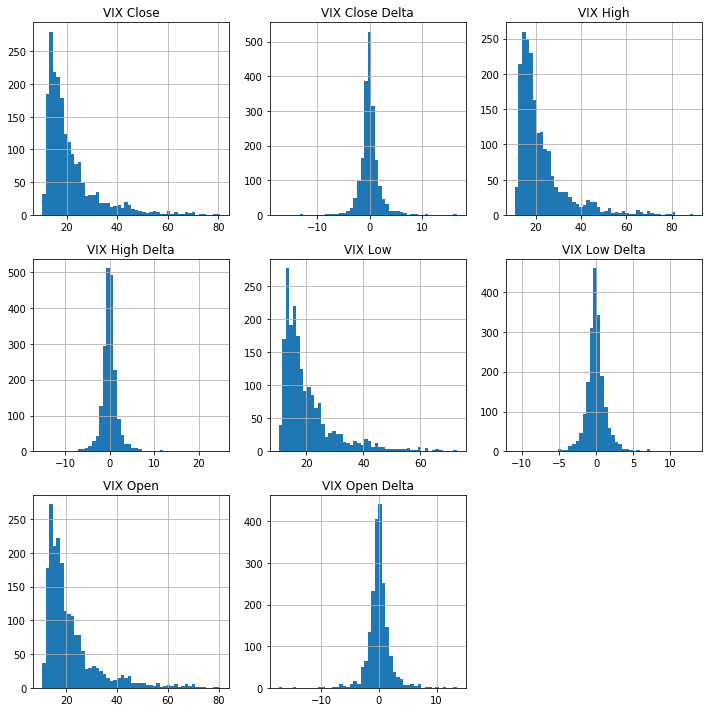

In [209]:
both_df.hist(bins=50,figsize=(10,10))
plt.tight_layout()

The original VIX data is tail heavy and we can see that converting to a delta VIX transforms the set to have a better shaped distribution.
#### Visualize Unit Vector of Full Data Set against VIX


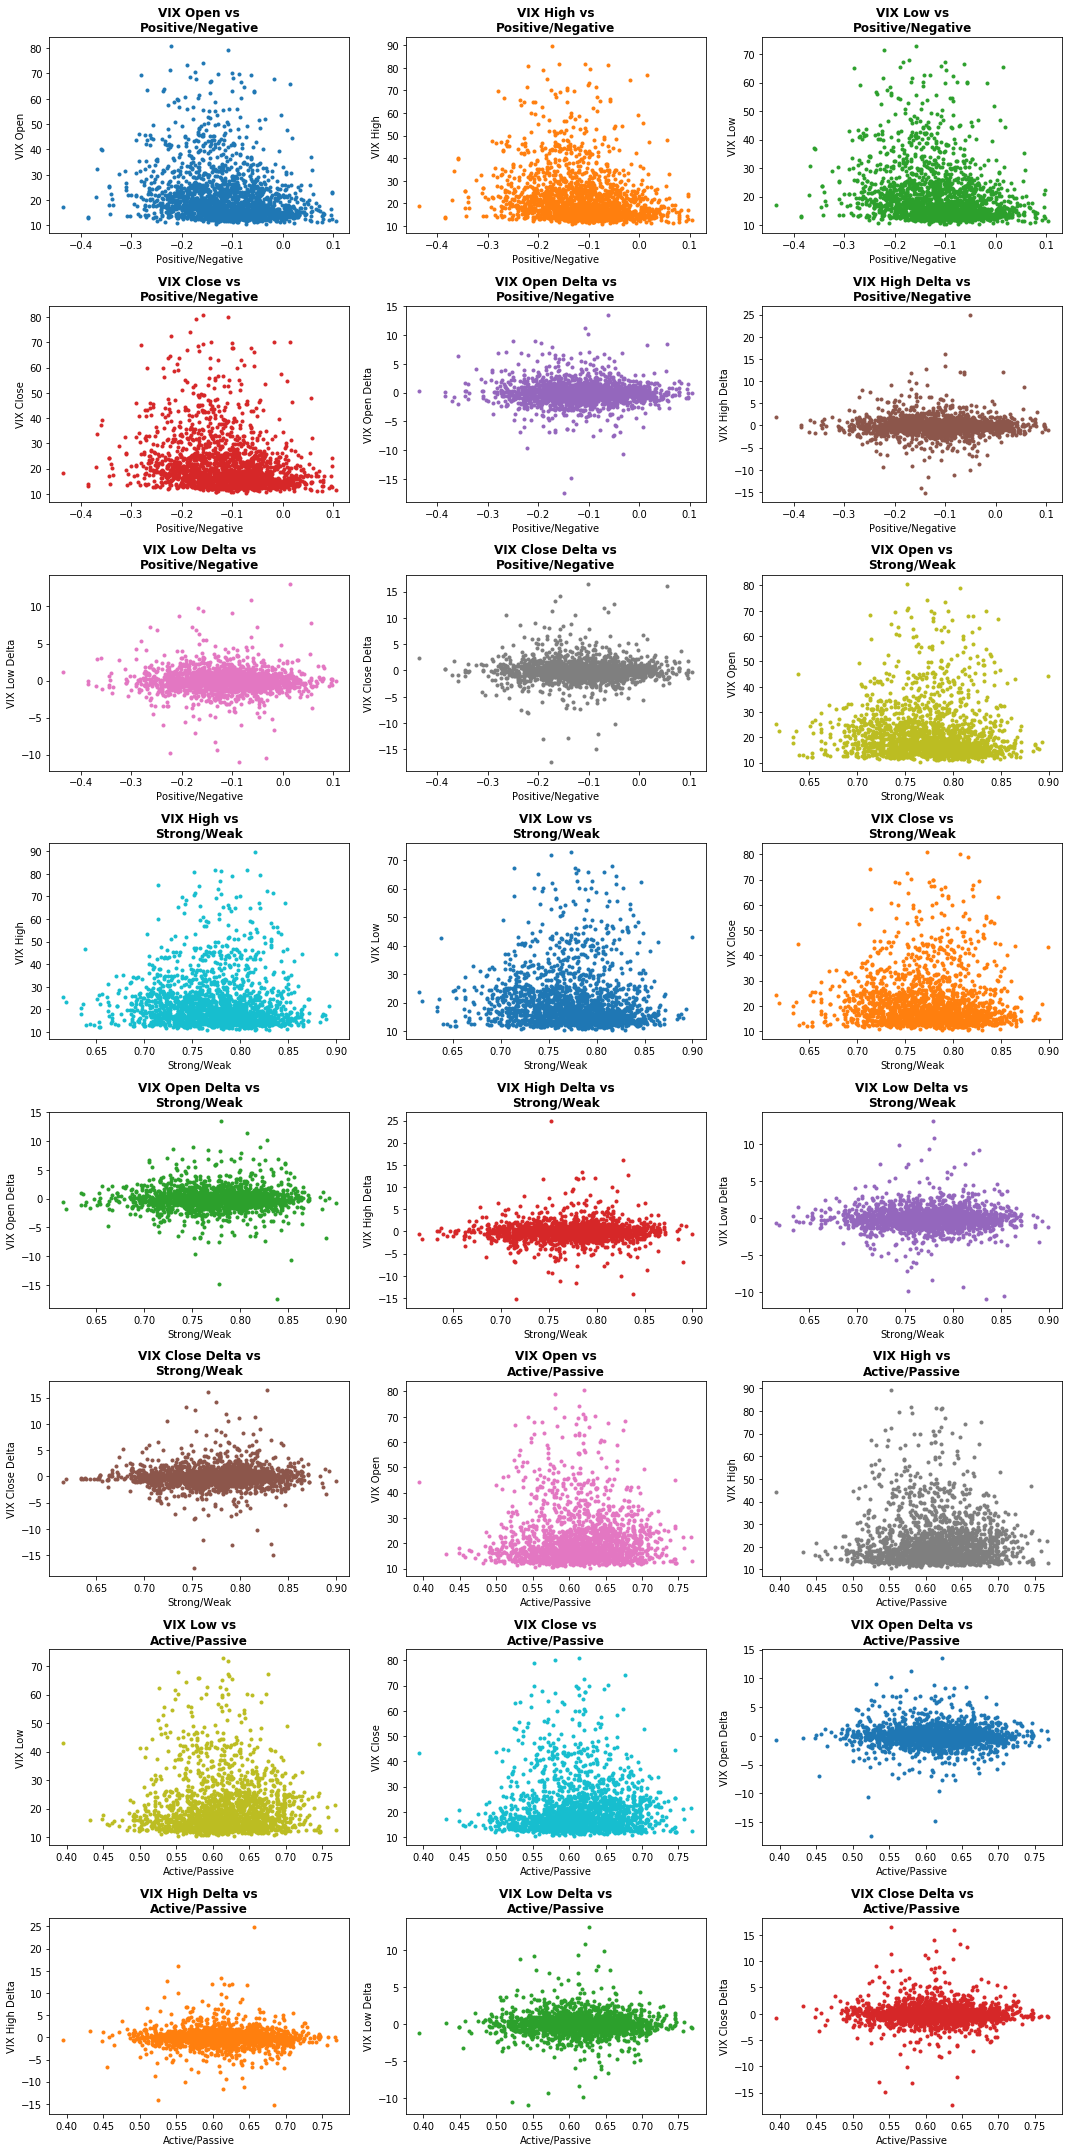

In [210]:
from matplotlib import colors as mcolors

VECT_NAME = ['Positive/Negative','Strong/Weak','Active/Passive']

# Get Vectors and Columns to graph
uvs = getSentArray(both_df['Unit Vect Sent'])
cols = list(both_df.columns[-8:])

# create figure
plt.figure(figsize=(15,30))
k = 1
for i in range(len(VECT_NAME)):
    # Loop of each Vector Component
    for col in cols:
        # for VIX deltas
        plt.subplot(len(cols),len(VECT_NAME),k)
        plt.plot(uvs[:,i],both_df[col].values,'.',color=next(COLORS)[1])
        plt.title(col + ' vs\n' + VECT_NAME[i],fontweight='bold')
        plt.xlabel(VECT_NAME[i])
        plt.ylabel(col)
        k = k + 1
plt.tight_layout()       

It looks like something is perhaps going on in the Delta VIX data.


### Build Test,Training and Validation Sets
Since sequence matters, we separate test and training data by date ranges.

In [211]:
'''Create Test and Train Splits'''
TEST_SPLIT = 0.2  #20% test data
test_data_sets = []
train_data_sets = []
for data in data_sets:
    len_test = int(np.floor(len(data.index)*TEST_SPLIT))
    test_data_sets.append(data.iloc[-len_test:])
    train_data_sets.append(data.drop(index=data[-len_test:].index))

# Check Splits
for i,test in enumerate(test_data_sets):
    print('===================================')
    print(['Full Data:','ABC Data:','Reddit Data:'][i])
    print('Data Length: ',len(data_sets[i]))
    print('Test Set: ',test.shape,
          ', {:0.1f}%'.format(test.shape[0]/len(data_sets[i])*100))
    print('Train Set: ',train_data_sets[i].shape,
         ', {:0.1f}%'.format(train_data_sets[i].shape[0]/len(data_sets[i])*100))
    
    

Full Data:
Data Length:  1989
Test Set:  (397, 11) , 20.0%
Train Set:  (1592, 11) , 80.0%
ABC Data:
Data Length:  4238
Test Set:  (847, 11) , 20.0%
Train Set:  (3391, 11) , 80.0%
Reddit Data:
Data Length:  1989
Test Set:  (397, 11) , 20.0%
Train Set:  (1592, 11) , 80.0%


In [212]:
'''Create Pipeline for data preparation'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin


class ParseVector(BaseEstimator,TransformerMixin):
    '''Transform Class for use with Pipeline to Parse Vectors
    for X values'''
    def __init__(self):
        return None
    def fit(self,X):
        return self
    def transform(self,X):
        return getSentArray(X)
    
class X_Slice(BaseEstimator,TransformerMixin):
    '''Transform to Slice X Data For RNN'''
    def __init__(self,step_size):
        self.step_size = step_size
    def fit (self,X,y=None):
        return self
    def transform(self,X,y=None):
        # 2d array to slices
        m = self.step_size
        n = X.shape[1]
        p = X.shape[0] -self.step_size
        xs = np.zeros((p,m,n))
        for i in range(0,p):
            xs[i,:,:] = X[i:m+i,:]
        return xs
    
class Y_Slice(BaseEstimator,TransformerMixin):
    '''Transform to Slice Y Data For RNN'''
    def __init__(self,step_size):
        self.step_size = step_size
    def fit (self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X.values[self.step_size:]
    
class X_Combine(BaseEstimator,TransformerMixin):
    '''Combine Two X Data Sets'''
    def __init__(self,shape1,shape2):
        self.shape1 = shape1
        self.shape2 = shape2
    def fit(self,X,y=None):
        return self
    def transform(self,X,y):
        s0 = self.shape1 + self.shape2
        s1 = self.shape1[1]
        s2 = self.shape1[2]
        return np.append(X,y).reshape(s0,s1,s2,axis=0)
    

#### Build Pipeline

In [213]:
STEP_SIZE = 20  # number of notes in a sequence slice


avgcumm_pipeline = Pipeline([
    ('parse',ParseVector()),
    ('minmax',MinMaxScaler(feature_range=(-1,1))),
    ('slice',X_Slice(step_size=STEP_SIZE))
])

unit_pipeline = Pipeline([
    ('parse',ParseVector()),
    ('slice',X_Slice(step_size=STEP_SIZE))
])


vix_pipeline = Pipeline([
    ('slice',Y_Slice(step_size=STEP_SIZE))
])

# create list of pipelines for x columns
x_pipes = [avgcumm_pipeline,avgcumm_pipeline,unit_pipeline]

#### Try The Different Data Sets With The Varried Targets With a Simple Network

In [216]:
'''Compile Simple Model'''
model =  create_model(lstm=True,n_nodes=64,
                      n_dropout=0.2,n_learning_rate=0.001,step_size=STEP_SIZE)
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 64)                17408     
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 64        
_________________________________________________________________
batch_normalization_17 (Batc (None, 1)                 4         
_________________________________________________________________
activation_17 (Activation)   (None, 1)                 0         
Total params: 17,476
Trainable params: 17,474
Non-trainable params: 2
_________________________________________________________________


In [36]:
EPOCH = 50
BATCH = 32
VALID_SPLIT = 0.1
# Define file to save intial weights so we can try each model
# without recomplining it
test_w_fp = os.path.join(curr_dir, 'saves','init_weights.hdf5')

# Try models and keep hist of each
history_dict = {}
model.save_weights(test_w_fp)
for i,train_data in enumerate(train_data_sets):
    x_cols = train_data.columns[:3]
    y_cols = train_data.columns[-8:]
    for x_data in x_cols:
        model.load_weights(test_w_fp)
        X_train = x_pipes[i].fit_transform(train_data[x_data])
        for y_data in y_cols:
            combo = str(x_data) +'\n' + str(y_data)
            print('==========================\n',combo)
            y_train = vix_pipeline.fit_transform(train_data[y_data])
            np.random.seed(42)
            hist = model.fit(X_train, y_train,
                             validation_split=VALID_SPLIT,
                             batch_size=BATCH,
                             epochs=EPOCH,
                             verbose=1) 
            history_dict[combo] = hist
done()

 Cummulative Sent
VIX Open
Train on 1414 samples, validate on 158 samples
Epoch 1/50
1414/1414 [==============================] - 1s 555us/step - loss: 671.2840 - val_loss: 203.1160
Epoch 2/50
1414/1414 [==============================] - 0s 293us/step - loss: 666.1554 - val_loss: 212.0861
Epoch 3/50
1414/1414 [==============================] - 0s 263us/step - loss: 662.7694 - val_loss: 205.5891
Epoch 4/50
1414/1414 [==============================] - 0s 281us/step - loss: 659.8384 - val_loss: 208.3433
Epoch 5/50
1414/1414 [==============================] - 0s 316us/step - loss: 657.3727 - val_loss: 202.7766
Epoch 6/50
1414/1414 [==============================] - 0s 270us/step - loss: 654.1981 - val_loss: 206.2094
Epoch 7/50
1414/1414 [==============================] - 0s 255us/step - loss: 651.6440 - val_loss: 202.6534
Epoch 8/50
1414/1414 [==============================] - 0s 256us/step - loss: 649.1184 - val_loss: 199.2109
Epoch 9/50
1414/1414 [==============================] - 0s 258

1414/1414 [==============================] - 1s 454us/step - loss: 277.4281 - val_loss: 132.8630
Epoch 49/50
1414/1414 [==============================] - 1s 446us/step - loss: 281.4726 - val_loss: 103.7710
Epoch 50/50
1414/1414 [==============================] - 1s 418us/step - loss: 277.2538 - val_loss: 103.5702
 Cummulative Sent
VIX Close
Train on 1414 samples, validate on 158 samples
Epoch 1/50
1414/1414 [==============================] - 0s 319us/step - loss: 312.6490 - val_loss: 115.3381
Epoch 2/50
1414/1414 [==============================] - 0s 352us/step - loss: 309.9156 - val_loss: 116.1717
Epoch 3/50
1414/1414 [==============================] - 0s 287us/step - loss: 307.1730 - val_loss: 104.6088
Epoch 4/50
1414/1414 [==============================] - 0s 281us/step - loss: 304.6205 - val_loss: 115.2021
Epoch 5/50
1414/1414 [==============================] - 1s 385us/step - loss: 304.4698 - val_loss: 106.1694
Epoch 6/50
1414/1414 [==============================] - 0s 315us/step 

1414/1414 [==============================] - 0s 260us/step - loss: 67.3587 - val_loss: 68.4115
Epoch 23/50
1414/1414 [==============================] - 0s 269us/step - loss: 66.7627 - val_loss: 72.1473
Epoch 24/50
1414/1414 [==============================] - 0s 262us/step - loss: 66.2926 - val_loss: 71.5069
Epoch 25/50
1414/1414 [==============================] - 0s 263us/step - loss: 65.6267 - val_loss: 60.8338
Epoch 26/50
1414/1414 [==============================] - 0s 263us/step - loss: 65.1350 - val_loss: 50.7674
Epoch 27/50
1414/1414 [==============================] - 0s 275us/step - loss: 64.6537 - val_loss: 76.8551
Epoch 28/50
1414/1414 [==============================] - 0s 250us/step - loss: 64.0897 - val_loss: 67.7095
Epoch 29/50
1414/1414 [==============================] - 0s 256us/step - loss: 63.5208 - val_loss: 59.9381
Epoch 30/50
1414/1414 [==============================] - 0s 271us/step - loss: 63.0023 - val_loss: 49.9430
Epoch 31/50
1414/1414 [==========================

Epoch 22/50
1414/1414 [==============================] - 0s 271us/step - loss: 11.0029 - val_loss: 4.6236
Epoch 23/50
1414/1414 [==============================] - 0s 283us/step - loss: 10.8482 - val_loss: 7.9632
Epoch 24/50
1414/1414 [==============================] - 0s 262us/step - loss: 10.6865 - val_loss: 3.6796
Epoch 25/50
1414/1414 [==============================] - 0s 282us/step - loss: 10.5182 - val_loss: 3.8722
Epoch 26/50
1414/1414 [==============================] - 0s 267us/step - loss: 10.3492 - val_loss: 4.9846
Epoch 27/50
1414/1414 [==============================] - 0s 271us/step - loss: 10.2169 - val_loss: 4.4506
Epoch 28/50
1414/1414 [==============================] - 0s 278us/step - loss: 10.0446 - val_loss: 5.6412
Epoch 29/50
1414/1414 [==============================] - 0s 283us/step - loss: 9.8795 - val_loss: 6.3878
Epoch 30/50
1414/1414 [==============================] - 0s 282us/step - loss: 9.8017 - val_loss: 8.3891
Epoch 31/50
1414/1414 [=========================

1414/1414 [==============================] - 0s 287us/step - loss: 277.6067 - val_loss: 165.3780
Epoch 21/50
1414/1414 [==============================] - 0s 287us/step - loss: 274.4943 - val_loss: 159.5463
Epoch 22/50
1414/1414 [==============================] - 0s 282us/step - loss: 271.8890 - val_loss: 161.7509
Epoch 23/50
1414/1414 [==============================] - 0s 287us/step - loss: 270.5764 - val_loss: 154.1010
Epoch 24/50
1414/1414 [==============================] - 0s 276us/step - loss: 271.1223 - val_loss: 147.6750
Epoch 25/50
1414/1414 [==============================] - 0s 287us/step - loss: 267.2511 - val_loss: 158.9202
Epoch 26/50
1414/1414 [==============================] - 0s 287us/step - loss: 265.8757 - val_loss: 163.4681
Epoch 27/50
1414/1414 [==============================] - 0s 281us/step - loss: 263.2730 - val_loss: 129.3793
Epoch 28/50
1414/1414 [==============================] - 0s 298us/step - loss: 263.8833 - val_loss: 158.6674
Epoch 29/50
1414/1414 [========

Epoch 19/50
1414/1414 [==============================] - 0s 325us/step - loss: 52.2818 - val_loss: 48.8612
Epoch 20/50
1414/1414 [==============================] - 0s 315us/step - loss: 51.7316 - val_loss: 51.0672
Epoch 21/50
1414/1414 [==============================] - 0s 317us/step - loss: 51.2669 - val_loss: 42.9109
Epoch 22/50
1414/1414 [==============================] - 0s 343us/step - loss: 50.7304 - val_loss: 58.9833
Epoch 23/50
1414/1414 [==============================] - 0s 305us/step - loss: 50.1451 - val_loss: 75.7830
Epoch 24/50
1414/1414 [==============================] - 0s 341us/step - loss: 49.7057 - val_loss: 37.2716
Epoch 25/50
1414/1414 [==============================] - 0s 351us/step - loss: 49.1435 - val_loss: 47.1899
Epoch 26/50
1414/1414 [==============================] - 0s 347us/step - loss: 48.4667 - val_loss: 72.3103
Epoch 27/50
1414/1414 [==============================] - 0s 332us/step - loss: 47.9793 - val_loss: 36.6486
Epoch 28/50
1414/1414 [==============

Epoch 19/50
1414/1414 [==============================] - 1s 376us/step - loss: 577.3968 - val_loss: 221.6978
Epoch 20/50
1414/1414 [==============================] - 0s 352us/step - loss: 574.2808 - val_loss: 220.7645
Epoch 21/50
1414/1414 [==============================] - 0s 322us/step - loss: 570.4114 - val_loss: 210.1595
Epoch 22/50
1414/1414 [==============================] - 0s 312us/step - loss: 567.1467 - val_loss: 219.0891
Epoch 23/50
1414/1414 [==============================] - 0s 339us/step - loss: 563.2800 - val_loss: 221.9304
Epoch 24/50
1414/1414 [==============================] - 0s 338us/step - loss: 561.6423 - val_loss: 213.1154
Epoch 25/50
1414/1414 [==============================] - 0s 340us/step - loss: 557.0808 - val_loss: 222.4661
Epoch 26/50
1414/1414 [==============================] - 0s 313us/step - loss: 554.4362 - val_loss: 222.0931
Epoch 27/50
1414/1414 [==============================] - 1s 360us/step - loss: 548.7129 - val_loss: 222.1271
Epoch 28/50
1414/14

1414/1414 [==============================] - 0s 309us/step - loss: 245.8384 - val_loss: 153.9685
Epoch 17/50
1414/1414 [==============================] - 0s 307us/step - loss: 241.8882 - val_loss: 161.3622
Epoch 18/50
1414/1414 [==============================] - 0s 305us/step - loss: 240.1272 - val_loss: 164.3299
Epoch 19/50
1414/1414 [==============================] - 0s 304us/step - loss: 236.9550 - val_loss: 155.8338
Epoch 20/50
1414/1414 [==============================] - 1s 361us/step - loss: 236.2169 - val_loss: 148.2729
Epoch 21/50
1414/1414 [==============================] - 1s 365us/step - loss: 233.1356 - val_loss: 168.8485
Epoch 22/50
1414/1414 [==============================] - 0s 338us/step - loss: 230.8834 - val_loss: 138.4917
Epoch 23/50
1414/1414 [==============================] - 0s 327us/step - loss: 230.8249 - val_loss: 150.0690
Epoch 24/50
1414/1414 [==============================] - 0s 317us/step - loss: 232.3717 - val_loss: 157.1029
Epoch 25/50
1414/1414 [========

1414/1414 [==============================] - 1s 356us/step - loss: 67.3093 - val_loss: 50.2702
Epoch 42/50
1414/1414 [==============================] - 1s 363us/step - loss: 66.6878 - val_loss: 66.5829
Epoch 43/50
1414/1414 [==============================] - 0s 322us/step - loss: 65.9697 - val_loss: 67.1600
Epoch 44/50
1414/1414 [==============================] - 0s 305us/step - loss: 65.4196 - val_loss: 38.4211
Epoch 45/50
1414/1414 [==============================] - 0s 305us/step - loss: 64.7876 - val_loss: 44.6362
Epoch 46/50
1414/1414 [==============================] - 0s 305us/step - loss: 64.1004 - val_loss: 35.7219
Epoch 47/50
1414/1414 [==============================] - 0s 340us/step - loss: 63.6912 - val_loss: 54.1923
Epoch 48/50
1414/1414 [==============================] - 0s 302us/step - loss: 62.8981 - val_loss: 47.9098
Epoch 49/50
1414/1414 [==============================] - 0s 330us/step - loss: 62.5792 - val_loss: 89.3110
Epoch 50/50
1414/1414 [==========================

Epoch 16/50
1414/1414 [==============================] - 0s 299us/step - loss: 28.0156 - val_loss: 17.8448
Epoch 17/50
1414/1414 [==============================] - 0s 300us/step - loss: 27.6431 - val_loss: 24.0823
Epoch 18/50
1414/1414 [==============================] - 0s 296us/step - loss: 27.1502 - val_loss: 25.9046
Epoch 19/50
1414/1414 [==============================] - 0s 300us/step - loss: 26.8325 - val_loss: 31.7798
Epoch 20/50
1414/1414 [==============================] - 0s 303us/step - loss: 26.5192 - val_loss: 26.5076
Epoch 21/50
1414/1414 [==============================] - 0s 303us/step - loss: 26.1930 - val_loss: 19.3124
Epoch 22/50
1414/1414 [==============================] - 0s 307us/step - loss: 25.7630 - val_loss: 24.5235
Epoch 23/50
1414/1414 [==============================] - 0s 298us/step - loss: 25.4334 - val_loss: 25.9939
Epoch 24/50
1414/1414 [==============================] - 0s 302us/step - loss: 25.0592 - val_loss: 17.2515
Epoch 25/50
1414/1414 [==============

Epoch 42/50
1414/1414 [==============================] - 0s 320us/step - loss: 10.4942 - val_loss: 3.7039
Epoch 43/50
1414/1414 [==============================] - 0s 320us/step - loss: 10.0427 - val_loss: 5.7849
Epoch 44/50
1414/1414 [==============================] - 0s 311us/step - loss: 9.9429 - val_loss: 5.8668
Epoch 45/50
1414/1414 [==============================] - 0s 313us/step - loss: 9.7068 - val_loss: 6.2011
Epoch 46/50
1414/1414 [==============================] - 0s 320us/step - loss: 9.6297 - val_loss: 4.5041
Epoch 47/50
1414/1414 [==============================] - 0s 321us/step - loss: 9.5280 - val_loss: 5.1658
Epoch 48/50
1414/1414 [==============================] - 0s 320us/step - loss: 9.2206 - val_loss: 4.6101
Epoch 49/50
1414/1414 [==============================] - 0s 314us/step - loss: 9.2963 - val_loss: 5.4141
Epoch 50/50
1414/1414 [==============================] - 1s 449us/step - loss: 9.0110 - val_loss: 3.4708
 ABC Cummulative Sent
VIX Open
Train on 3033 samples,

3033/3033 [==============================] - 1s 305us/step - loss: 47.1298 - val_loss: 60.6497
Epoch 41/50
3033/3033 [==============================] - 1s 317us/step - loss: 47.1284 - val_loss: 62.8856
Epoch 42/50
3033/3033 [==============================] - 1s 303us/step - loss: 47.3463 - val_loss: 49.6327
Epoch 43/50
3033/3033 [==============================] - 1s 298us/step - loss: 44.2797 - val_loss: 51.8582
Epoch 44/50
3033/3033 [==============================] - 1s 296us/step - loss: 49.8060 - val_loss: 55.4578
Epoch 45/50
3033/3033 [==============================] - 1s 296us/step - loss: 47.7514 - val_loss: 57.7672
Epoch 46/50
3033/3033 [==============================] - 1s 296us/step - loss: 44.5404 - val_loss: 54.2242
Epoch 47/50
3033/3033 [==============================] - 1s 306us/step - loss: 44.4460 - val_loss: 51.3697
Epoch 48/50
3033/3033 [==============================] - 1s 297us/step - loss: 41.5436 - val_loss: 51.8347
Epoch 49/50
3033/3033 [==========================

3033/3033 [==============================] - 1s 421us/step - loss: 72.4256 - val_loss: 78.2917
Epoch 39/50
3033/3033 [==============================] - 1s 362us/step - loss: 70.9648 - val_loss: 63.8193
Epoch 40/50
3033/3033 [==============================] - 1s 297us/step - loss: 69.6306 - val_loss: 58.5418
Epoch 41/50
3033/3033 [==============================] - 1s 297us/step - loss: 68.2026 - val_loss: 76.3407
Epoch 42/50
3033/3033 [==============================] - 1s 365us/step - loss: 66.8105 - val_loss: 71.0699
Epoch 43/50
3033/3033 [==============================] - 1s 371us/step - loss: 65.4800 - val_loss: 57.3110
Epoch 44/50
3033/3033 [==============================] - 1s 354us/step - loss: 64.1414 - val_loss: 72.1405
Epoch 45/50
3033/3033 [==============================] - 1s 319us/step - loss: 62.8192 - val_loss: 66.5010
Epoch 46/50
3033/3033 [==============================] - 1s 327us/step - loss: 61.5459 - val_loss: 85.2880
Epoch 47/50
3033/3033 [==========================

Epoch 13/50
3033/3033 [==============================] - 1s 297us/step - loss: 8.5436 - val_loss: 11.5927
Epoch 14/50
3033/3033 [==============================] - 1s 302us/step - loss: 8.2025 - val_loss: 11.1217
Epoch 15/50
3033/3033 [==============================] - 1s 310us/step - loss: 7.9190 - val_loss: 8.7307
Epoch 16/50
3033/3033 [==============================] - 1s 296us/step - loss: 7.5791 - val_loss: 5.3593
Epoch 17/50
3033/3033 [==============================] - 1s 294us/step - loss: 7.1773 - val_loss: 7.5169
Epoch 18/50
3033/3033 [==============================] - 1s 292us/step - loss: 6.9602 - val_loss: 4.5054
Epoch 19/50
3033/3033 [==============================] - 1s 291us/step - loss: 6.5991 - val_loss: 6.6437
Epoch 20/50
3033/3033 [==============================] - 1s 291us/step - loss: 6.3706 - val_loss: 8.8936
Epoch 21/50
3033/3033 [==============================] - 1s 297us/step - loss: 6.1195 - val_loss: 8.1422
Epoch 22/50
3033/3033 [==============================

Epoch 12/50
3033/3033 [==============================] - 1s 321us/step - loss: 72.6159 - val_loss: 41.1663
Epoch 13/50
3033/3033 [==============================] - 1s 294us/step - loss: 69.3397 - val_loss: 42.7010
Epoch 14/50
3033/3033 [==============================] - 1s 292us/step - loss: 68.1564 - val_loss: 37.7522
Epoch 15/50
3033/3033 [==============================] - 1s 292us/step - loss: 68.4608 - val_loss: 41.4946
Epoch 16/50
3033/3033 [==============================] - 1s 292us/step - loss: 67.0730 - val_loss: 37.6192
Epoch 17/50
3033/3033 [==============================] - 1s 292us/step - loss: 65.6855 - val_loss: 37.7785
Epoch 18/50
3033/3033 [==============================] - 1s 308us/step - loss: 65.0803 - val_loss: 31.5868
Epoch 19/50
3033/3033 [==============================] - 1s 325us/step - loss: 65.6939 - val_loss: 35.7675
Epoch 20/50
3033/3033 [==============================] - 1s 299us/step - loss: 60.8877 - val_loss: 45.3509
Epoch 21/50
3033/3033 [==============

3033/3033 [==============================] - 1s 292us/step - loss: 117.8244 - val_loss: 138.5942
Epoch 11/50
3033/3033 [==============================] - 1s 292us/step - loss: 115.9705 - val_loss: 101.9649
Epoch 12/50
3033/3033 [==============================] - 1s 297us/step - loss: 114.1206 - val_loss: 112.5047
Epoch 13/50
3033/3033 [==============================] - 1s 290us/step - loss: 112.2975 - val_loss: 105.6387
Epoch 14/50
3033/3033 [==============================] - 1s 292us/step - loss: 110.4386 - val_loss: 104.3393
Epoch 15/50
3033/3033 [==============================] - 1s 297us/step - loss: 108.6679 - val_loss: 112.0473
Epoch 16/50
3033/3033 [==============================] - 1s 317us/step - loss: 106.8437 - val_loss: 105.5701
Epoch 17/50
3033/3033 [==============================] - 1s 310us/step - loss: 105.1451 - val_loss: 106.5871
Epoch 18/50
3033/3033 [==============================] - 1s 315us/step - loss: 103.3764 - val_loss: 90.5695
Epoch 19/50
3033/3033 [=========

3033/3033 [==============================] - 1s 315us/step - loss: 378.3873 - val_loss: 279.4854
Epoch 11/50
3033/3033 [==============================] - 1s 330us/step - loss: 373.3892 - val_loss: 251.9729
Epoch 12/50
3033/3033 [==============================] - 1s 341us/step - loss: 368.7876 - val_loss: 242.8233
Epoch 13/50
3033/3033 [==============================] - 1s 315us/step - loss: 363.6812 - val_loss: 209.4796
Epoch 14/50
3033/3033 [==============================] - 1s 290us/step - loss: 359.4189 - val_loss: 237.1428
Epoch 15/50
3033/3033 [==============================] - 1s 288us/step - loss: 355.0075 - val_loss: 270.8984
Epoch 16/50
3033/3033 [==============================] - 1s 296us/step - loss: 351.0116 - val_loss: 247.9027
Epoch 17/50
3033/3033 [==============================] - 1s 295us/step - loss: 346.2812 - val_loss: 245.1951
Epoch 18/50
3033/3033 [==============================] - 1s 301us/step - loss: 342.1439 - val_loss: 239.6380
Epoch 19/50
3033/3033 [========

3033/3033 [==============================] - 1s 310us/step - loss: 59.4664 - val_loss: 36.2763
Epoch 9/50
3033/3033 [==============================] - 1s 295us/step - loss: 57.4540 - val_loss: 41.2803
Epoch 10/50
3033/3033 [==============================] - 1s 292us/step - loss: 57.8092 - val_loss: 46.9738
Epoch 11/50
3033/3033 [==============================] - 1s 292us/step - loss: 58.2960 - val_loss: 51.1530
Epoch 12/50
3033/3033 [==============================] - 1s 302us/step - loss: 57.7532 - val_loss: 41.9432
Epoch 13/50
3033/3033 [==============================] - 1s 295us/step - loss: 51.8505 - val_loss: 46.2630
Epoch 14/50
3033/3033 [==============================] - 1s 311us/step - loss: 52.0933 - val_loss: 54.1933
Epoch 15/50
3033/3033 [==============================] - 1s 318us/step - loss: 54.3886 - val_loss: 51.8593
Epoch 16/50
3033/3033 [==============================] - 1s 325us/step - loss: 52.3754 - val_loss: 44.1967
Epoch 17/50
3033/3033 [===========================

3033/3033 [==============================] - 1s 292us/step - loss: 52.5347 - val_loss: 60.5533
Epoch 8/50
3033/3033 [==============================] - 1s 297us/step - loss: 51.3391 - val_loss: 55.0190
Epoch 9/50
3033/3033 [==============================] - 1s 325us/step - loss: 50.1647 - val_loss: 39.5074
Epoch 10/50
3033/3033 [==============================] - 1s 353us/step - loss: 49.0182 - val_loss: 55.0549
Epoch 11/50
3033/3033 [==============================] - 1s 318us/step - loss: 47.8484 - val_loss: 46.0124
Epoch 12/50
3033/3033 [==============================] - 1s 320us/step - loss: 46.7329 - val_loss: 47.3683
Epoch 13/50
3033/3033 [==============================] - 1s 314us/step - loss: 45.6961 - val_loss: 47.9031
Epoch 14/50
3033/3033 [==============================] - 1s 293us/step - loss: 44.5502 - val_loss: 46.9234
Epoch 15/50
3033/3033 [==============================] - 1s 294us/step - loss: 43.4546 - val_loss: 50.6652
Epoch 16/50
3033/3033 [============================

3033/3033 [==============================] - 1s 330us/step - loss: 4.8660 - val_loss: 5.9379
Epoch 34/50
3033/3033 [==============================] - 1s 318us/step - loss: 4.6357 - val_loss: 4.7614
Epoch 35/50
3033/3033 [==============================] - 1s 315us/step - loss: 4.5261 - val_loss: 4.6324
Epoch 36/50
3033/3033 [==============================] - 1s 297us/step - loss: 4.4160 - val_loss: 6.1386
Epoch 37/50
3033/3033 [==============================] - 1s 287us/step - loss: 4.2378 - val_loss: 4.6012
Epoch 38/50
3033/3033 [==============================] - 1s 292us/step - loss: 4.1325 - val_loss: 5.0261
Epoch 39/50
3033/3033 [==============================] - 1s 290us/step - loss: 3.9480 - val_loss: 4.3471
Epoch 40/50
3033/3033 [==============================] - 1s 296us/step - loss: 3.8819 - val_loss: 3.9176
Epoch 41/50
3033/3033 [==============================] - 1s 293us/step - loss: 3.7489 - val_loss: 3.9698
Epoch 42/50
3033/3033 [==============================] - 1s 296us/s

1414/1414 [==============================] - 0s 295us/step - loss: 501.1574 - val_loss: 173.4365
Epoch 8/50
1414/1414 [==============================] - 0s 299us/step - loss: 498.7035 - val_loss: 186.9104
Epoch 9/50
1414/1414 [==============================] - 0s 295us/step - loss: 496.8494 - val_loss: 189.3765
Epoch 10/50
1414/1414 [==============================] - 0s 294us/step - loss: 494.5894 - val_loss: 191.9450
Epoch 11/50
1414/1414 [==============================] - 0s 295us/step - loss: 490.1680 - val_loss: 180.0996
Epoch 12/50
1414/1414 [==============================] - 0s 295us/step - loss: 486.7241 - val_loss: 177.6430
Epoch 13/50
1414/1414 [==============================] - 0s 299us/step - loss: 485.0180 - val_loss: 182.1419
Epoch 14/50
1414/1414 [==============================] - 0s 295us/step - loss: 483.8705 - val_loss: 124.1192
Epoch 15/50
1414/1414 [==============================] - 0s 298us/step - loss: 480.9651 - val_loss: 184.2038
Epoch 16/50
1414/1414 [==========

1414/1414 [==============================] - 0s 299us/step - loss: 96.0684 - val_loss: 83.4827
Epoch 5/50
1414/1414 [==============================] - 0s 306us/step - loss: 94.5212 - val_loss: 86.5475
Epoch 6/50
1414/1414 [==============================] - 0s 298us/step - loss: 93.8142 - val_loss: 76.9319
Epoch 7/50
1414/1414 [==============================] - 0s 290us/step - loss: 93.1056 - val_loss: 97.9050
Epoch 8/50
1414/1414 [==============================] - 0s 294us/step - loss: 92.3101 - val_loss: 73.9526
Epoch 9/50
1414/1414 [==============================] - 0s 288us/step - loss: 91.5816 - val_loss: 88.4348
Epoch 10/50
1414/1414 [==============================] - 0s 306us/step - loss: 90.7279 - val_loss: 71.5646
Epoch 11/50
1414/1414 [==============================] - 0s 294us/step - loss: 90.1375 - val_loss: 91.9389
Epoch 12/50
1414/1414 [==============================] - 0s 295us/step - loss: 89.2877 - val_loss: 88.0496
Epoch 13/50
1414/1414 [==============================]

1414/1414 [==============================] - 0s 295us/step - loss: 19.0554 - val_loss: 8.0014
Epoch 4/50
1414/1414 [==============================] - 0s 295us/step - loss: 18.8202 - val_loss: 13.8859
Epoch 5/50
1414/1414 [==============================] - 0s 294us/step - loss: 18.6414 - val_loss: 18.7570
Epoch 6/50
1414/1414 [==============================] - 0s 298us/step - loss: 18.2163 - val_loss: 12.5607
Epoch 7/50
1414/1414 [==============================] - 0s 295us/step - loss: 17.8350 - val_loss: 19.7404
Epoch 8/50
1414/1414 [==============================] - 0s 295us/step - loss: 17.6414 - val_loss: 4.8198
Epoch 9/50
1414/1414 [==============================] - 0s 307us/step - loss: 17.5450 - val_loss: 12.5879
Epoch 10/50
1414/1414 [==============================] - 1s 376us/step - loss: 17.2887 - val_loss: 14.8615
Epoch 11/50
1414/1414 [==============================] - 0s 326us/step - loss: 16.7508 - val_loss: 6.7394
Epoch 12/50
1414/1414 [==============================] - 0

1414/1414 [==============================] - 0s 294us/step - loss: 344.5167 - val_loss: 112.1150
Epoch 2/50
1414/1414 [==============================] - 0s 289us/step - loss: 343.9902 - val_loss: 117.3317
Epoch 3/50
1414/1414 [==============================] - 0s 294us/step - loss: 342.7114 - val_loss: 115.2866
Epoch 4/50
1414/1414 [==============================] - 0s 294us/step - loss: 337.8857 - val_loss: 115.3578
Epoch 5/50
1414/1414 [==============================] - 0s 301us/step - loss: 339.5433 - val_loss: 113.3640
Epoch 6/50
1414/1414 [==============================] - 0s 304us/step - loss: 334.9387 - val_loss: 118.4261
Epoch 7/50
1414/1414 [==============================] - 0s 295us/step - loss: 337.1621 - val_loss: 110.1915
Epoch 8/50
1414/1414 [==============================] - 0s 305us/step - loss: 335.9918 - val_loss: 106.9074
Epoch 9/50
1414/1414 [==============================] - 0s 295us/step - loss: 333.7783 - val_loss: 117.1133
Epoch 10/50
1414/1414 [================

Epoch 26/50
1414/1414 [==============================] - 0s 294us/step - loss: 259.9017 - val_loss: 43.2838
Epoch 27/50
1414/1414 [==============================] - 0s 306us/step - loss: 259.0131 - val_loss: 65.8519
Epoch 28/50
1414/1414 [==============================] - 0s 295us/step - loss: 256.7822 - val_loss: 79.7010
Epoch 29/50
1414/1414 [==============================] - 0s 310us/step - loss: 258.7708 - val_loss: 43.2452
Epoch 30/50
1414/1414 [==============================] - 0s 296us/step - loss: 255.2804 - val_loss: 114.7160
Epoch 31/50
1414/1414 [==============================] - 0s 307us/step - loss: 253.9166 - val_loss: 90.2593
Epoch 32/50
1414/1414 [==============================] - 0s 292us/step - loss: 253.8514 - val_loss: 56.9172
Epoch 33/50
1414/1414 [==============================] - 0s 299us/step - loss: 252.5180 - val_loss: 48.1750
Epoch 34/50
1414/1414 [==============================] - 0s 339us/step - loss: 257.4281 - val_loss: 40.4708
Epoch 35/50
1414/1414 [====

1414/1414 [==============================] - 0s 298us/step - loss: 63.8989 - val_loss: 64.4917
Epoch 2/50
1414/1414 [==============================] - 0s 298us/step - loss: 63.1716 - val_loss: 54.3297
Epoch 3/50
1414/1414 [==============================] - 0s 295us/step - loss: 62.6234 - val_loss: 53.3641
Epoch 4/50
1414/1414 [==============================] - 0s 306us/step - loss: 62.0672 - val_loss: 46.4272
Epoch 5/50
1414/1414 [==============================] - 0s 295us/step - loss: 61.6359 - val_loss: 59.6909
Epoch 6/50
1414/1414 [==============================] - 0s 310us/step - loss: 60.8659 - val_loss: 63.7964
Epoch 7/50
1414/1414 [==============================] - 0s 295us/step - loss: 60.3605 - val_loss: 57.9962
Epoch 8/50
1414/1414 [==============================] - 0s 305us/step - loss: 59.7567 - val_loss: 57.4743
Epoch 9/50
1414/1414 [==============================] - 1s 354us/step - loss: 59.1028 - val_loss: 48.7716
Epoch 10/50
1414/1414 [==============================] - 

Epoch 27/50
1414/1414 [==============================] - 0s 331us/step - loss: 25.3515 - val_loss: 16.3496
Epoch 28/50
1414/1414 [==============================] - 0s 308us/step - loss: 24.9704 - val_loss: 24.0866
Epoch 29/50
1414/1414 [==============================] - 0s 294us/step - loss: 24.6507 - val_loss: 18.5545
Epoch 30/50
1414/1414 [==============================] - 0s 295us/step - loss: 24.2682 - val_loss: 26.2086
Epoch 31/50
1414/1414 [==============================] - 0s 295us/step - loss: 23.9837 - val_loss: 15.7022
Epoch 32/50
1414/1414 [==============================] - 0s 332us/step - loss: 23.5772 - val_loss: 17.2241
Epoch 33/50
1414/1414 [==============================] - 0s 343us/step - loss: 23.2803 - val_loss: 20.8551
Epoch 34/50
1414/1414 [==============================] - 0s 306us/step - loss: 22.8943 - val_loss: 27.7267
Epoch 35/50
1414/1414 [==============================] - 0s 295us/step - loss: 22.6219 - val_loss: 17.8091
Epoch 36/50
1414/1414 [==============

Epoch 2/50
1414/1414 [==============================] - 0s 295us/step - loss: 659.9809 - val_loss: 202.2709
Epoch 3/50
1414/1414 [==============================] - 0s 306us/step - loss: 651.5421 - val_loss: 188.9302
Epoch 4/50
1414/1414 [==============================] - 0s 294us/step - loss: 644.3666 - val_loss: 201.4191
Epoch 5/50
1414/1414 [==============================] - 0s 299us/step - loss: 639.1907 - val_loss: 197.1472
Epoch 6/50
1414/1414 [==============================] - 0s 303us/step - loss: 634.0837 - val_loss: 175.7802
Epoch 7/50
1414/1414 [==============================] - 0s 335us/step - loss: 629.5647 - val_loss: 158.5907
Epoch 8/50
1414/1414 [==============================] - 1s 359us/step - loss: 624.4735 - val_loss: 175.1739
Epoch 9/50
1414/1414 [==============================] - 0s 293us/step - loss: 620.2978 - val_loss: 188.5932
Epoch 10/50
1414/1414 [==============================] - 0s 302us/step - loss: 615.8095 - val_loss: 163.6038
Epoch 11/50
1414/1414 [====

 Reddit Unit Vect Sent
VIX Close
Train on 1414 samples, validate on 158 samples
Epoch 1/50
1414/1414 [==============================] - 0s 349us/step - loss: 276.9708 - val_loss: 76.1253
Epoch 2/50
1414/1414 [==============================] - 0s 300us/step - loss: 276.7286 - val_loss: 65.7794
Epoch 3/50
1414/1414 [==============================] - 0s 317us/step - loss: 275.7510 - val_loss: 53.0003
Epoch 4/50
1414/1414 [==============================] - 0s 332us/step - loss: 280.8642 - val_loss: 78.7204
Epoch 5/50
1414/1414 [==============================] - 0s 343us/step - loss: 280.2360 - val_loss: 40.1387
Epoch 6/50
1414/1414 [==============================] - 0s 332us/step - loss: 271.0795 - val_loss: 90.9042
Epoch 7/50
1414/1414 [==============================] - 0s 306us/step - loss: 273.2953 - val_loss: 62.8414
Epoch 8/50
1414/1414 [==============================] - 0s 300us/step - loss: 284.8567 - val_loss: 46.7519
Epoch 9/50
1414/1414 [==============================] - 0s 300us

1414/1414 [==============================] - 0s 310us/step - loss: 37.0172 - val_loss: 27.3550
 Reddit Unit Vect Sent
VIX Low Delta
Train on 1414 samples, validate on 158 samples
Epoch 1/50
1414/1414 [==============================] - 0s 339us/step - loss: 34.6363 - val_loss: 34.4519
Epoch 2/50
1414/1414 [==============================] - 0s 343us/step - loss: 34.2463 - val_loss: 28.6915
Epoch 3/50
1414/1414 [==============================] - 0s 321us/step - loss: 33.7734 - val_loss: 32.8989
Epoch 4/50
1414/1414 [==============================] - 0s 306us/step - loss: 33.3443 - val_loss: 36.2554
Epoch 5/50
1414/1414 [==============================] - 0s 297us/step - loss: 32.9722 - val_loss: 25.5303
Epoch 6/50
1414/1414 [==============================] - 0s 296us/step - loss: 32.4502 - val_loss: 33.4366
Epoch 7/50
1414/1414 [==============================] - 0s 299us/step - loss: 32.0730 - val_loss: 28.1757
Epoch 8/50
1414/1414 [==============================] - 0s 289us/step - loss: 3

Epoch 25/50
1414/1414 [==============================] - 1s 373us/step - loss: 13.3907 - val_loss: 8.4431
Epoch 26/50
1414/1414 [==============================] - 1s 389us/step - loss: 13.3355 - val_loss: 14.1282
Epoch 27/50
1414/1414 [==============================] - 0s 330us/step - loss: 13.0837 - val_loss: 10.9465
Epoch 28/50
1414/1414 [==============================] - 0s 328us/step - loss: 12.9062 - val_loss: 5.5677
Epoch 29/50
1414/1414 [==============================] - 0s 311us/step - loss: 12.6830 - val_loss: 9.2702
Epoch 30/50
1414/1414 [==============================] - 0s 343us/step - loss: 12.5258 - val_loss: 10.8166
Epoch 31/50
1414/1414 [==============================] - 0s 316us/step - loss: 12.3299 - val_loss: 9.2276
Epoch 32/50
1414/1414 [==============================] - 0s 306us/step - loss: 12.1403 - val_loss: 11.0633
Epoch 33/50
1414/1414 [==============================] - 0s 299us/step - loss: 12.1119 - val_loss: 7.2126
Epoch 34/50
1414/1414 [===================

### Plot the model histories

<img src='saves\initial_field.png'>
The VIX Close Delta seems to be the most promising target variable.  Some of the models are already achieving single digit loss.  

#### Taking a closer look at VIX Close Delta

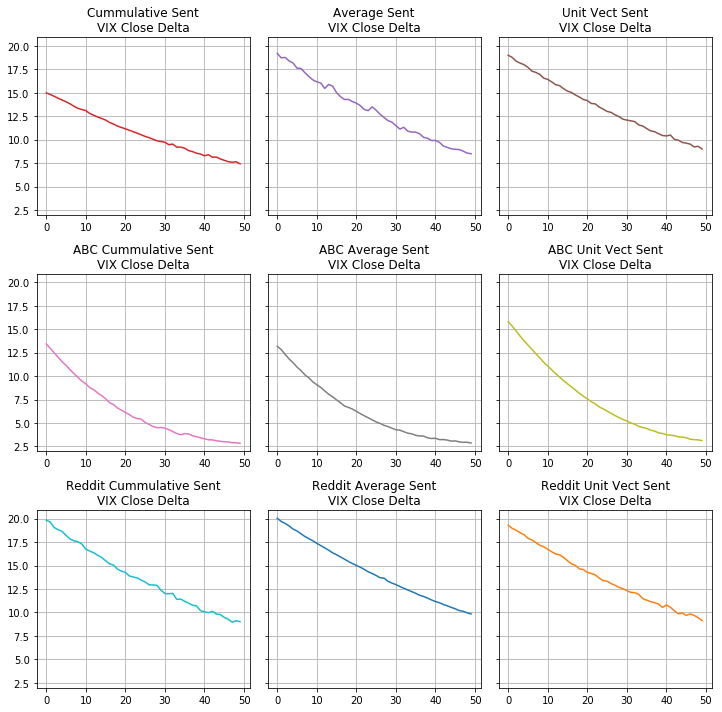

In [233]:
'''Get Titles with VIX Close Delta'''
narrowed = []
for _hist in history_dict.items():
    if 'VIX Close Delta' in _hist[0]:
        narrowed.append(_hist[0])

ROWS = 3
COL = 3
f, axes = plt.subplots(ROWS,COL,sharey=True)
f.set_size_inches(10,10)
axes = axes.flatten()

for k,_title in enumerate(narrowed):
    axes[k].plot(history_dict[_title].history['loss'],color=next(COLORS)[1])
    axes[k].set_title(_title)
    axes[k].grid()
plt.tight_layout()

### Train the Narrowed list for longer 
<img src='saves\narrowed_field1.png'>

In [235]:
EPOCH = 250
BATCH = 32
VALID_SPLIT = 0.1

# get narrowed x data columns
x_narrowed = []
for _x in narrowed:
    x_narrowed.append(_x.split('\n')[0])


# Try models and keep hist of each
narrowed_dict = {}
y_cols = ['VIX Close Delta']
k = 0
for train_data in train_data_sets:
    x_cols = list(set(train_data.columns) & set(x_narrowed))
    for x_data in x_cols:
        model.load_weights(test_w_fp)
        X_train = x_pipes[i].fit_transform(train_data[x_data])
        print('==========================\n',x_data)
        y_train = vix_pipeline.fit_transform(train_data[y_cols])
        np.random.seed(42)
        hist = model.fit(X_train, y_train,
                        validation_split=VALID_SPLIT,
                        batch_size=BATCH,
                        epochs=EPOCH,
                        verbose=1) 
        narrowed_dict[narrowed[k]] = hist
        k = k + 1
done()

 Average Sent
Train on 1414 samples, validate on 158 samples
Epoch 1/250
1414/1414 [==============================] - 1s 634us/step - loss: 5.2933 - accuracy: 0.0035 - val_loss: 1.2048 - val_accuracy: 0.0000e+00
Epoch 2/250
1414/1414 [==============================] - 0s 301us/step - loss: 5.2610 - accuracy: 0.0057 - val_loss: 1.2083 - val_accuracy: 0.0000e+00
Epoch 3/250
1414/1414 [==============================] - 0s 317us/step - loss: 5.1433 - accuracy: 0.0050 - val_loss: 1.2048 - val_accuracy: 0.0000e+00
Epoch 4/250
1414/1414 [==============================] - 0s 329us/step - loss: 5.1718 - accuracy: 0.0057 - val_loss: 1.2031 - val_accuracy: 0.0000e+00
Epoch 5/250
1414/1414 [==============================] - 0s 288us/step - loss: 5.1587 - accuracy: 0.0050 - val_loss: 1.2031 - val_accuracy: 0.0000e+00
Epoch 6/250
1414/1414 [==============================] - 0s 293us/step - loss: 5.1524 - accuracy: 0.0064 - val_loss: 1.2040 - val_accuracy: 0.0000e+00
Epoch 7/250
1414/1414 [==========

Epoch 108/250
1414/1414 [==============================] - 0s 289us/step - loss: 5.0698 - accuracy: 0.0057 - val_loss: 1.1979 - val_accuracy: 0.0000e+00
Epoch 109/250
1414/1414 [==============================] - 0s 293us/step - loss: 5.0786 - accuracy: 0.0057 - val_loss: 1.2076 - val_accuracy: 0.0000e+00
Epoch 110/250
1414/1414 [==============================] - 0s 300us/step - loss: 5.0824 - accuracy: 0.0057 - val_loss: 1.2135 - val_accuracy: 0.0000e+00
Epoch 111/250
1414/1414 [==============================] - 0s 296us/step - loss: 5.0771 - accuracy: 0.0057 - val_loss: 1.2058 - val_accuracy: 0.0000e+00
Epoch 112/250
1414/1414 [==============================] - 0s 288us/step - loss: 5.0789 - accuracy: 0.0057 - val_loss: 1.2069 - val_accuracy: 0.0000e+00
Epoch 113/250
1414/1414 [==============================] - 0s 288us/step - loss: 5.0743 - accuracy: 0.0057 - val_loss: 1.2126 - val_accuracy: 0.0000e+00
Epoch 114/250
1414/1414 [==============================] - 0s 293us/step - loss: 5

Epoch 215/250
1414/1414 [==============================] - 0s 320us/step - loss: 5.0641 - accuracy: 0.0057 - val_loss: 1.2004 - val_accuracy: 0.0000e+00
Epoch 216/250
1414/1414 [==============================] - 1s 595us/step - loss: 5.0725 - accuracy: 0.0057 - val_loss: 1.1940 - val_accuracy: 0.0000e+00
Epoch 217/250
1414/1414 [==============================] - 1s 385us/step - loss: 5.0686 - accuracy: 0.0057 - val_loss: 1.1964 - val_accuracy: 0.0000e+00
Epoch 218/250
1414/1414 [==============================] - 0s 316us/step - loss: 5.0667 - accuracy: 0.0057 - val_loss: 1.1902 - val_accuracy: 0.0000e+00
Epoch 219/250
1414/1414 [==============================] - 0s 334us/step - loss: 5.0660 - accuracy: 0.0057 - val_loss: 1.2343 - val_accuracy: 0.0000e+00
Epoch 220/250
1414/1414 [==============================] - 1s 356us/step - loss: 5.0674 - accuracy: 0.0057 - val_loss: 1.1944 - val_accuracy: 0.0000e+00
Epoch 221/250
1414/1414 [==============================] - 1s 362us/step - loss: 5

Epoch 72/250
1414/1414 [==============================] - 0s 300us/step - loss: 5.0787 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 73/250
1414/1414 [==============================] - 0s 300us/step - loss: 5.0792 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 74/250
1414/1414 [==============================] - 0s 298us/step - loss: 5.0783 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 75/250
1414/1414 [==============================] - 0s 303us/step - loss: 5.0795 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 76/250
1414/1414 [==============================] - 0s 298us/step - loss: 5.0785 - accuracy: 0.0057 - val_loss: 1.2024 - val_accuracy: 0.0000e+00
Epoch 77/250
1414/1414 [==============================] - 0s 319us/step - loss: 5.0795 - accuracy: 0.0057 - val_loss: 1.2024 - val_accuracy: 0.0000e+00
Epoch 78/250
1414/1414 [==============================] - 1s 384us/step - loss: 5.0791 -

1414/1414 [==============================] - 0s 317us/step - loss: 5.0773 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 179/250
1414/1414 [==============================] - 0s 309us/step - loss: 5.0787 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 180/250
1414/1414 [==============================] - 0s 325us/step - loss: 5.0805 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 181/250
1414/1414 [==============================] - 0s 322us/step - loss: 5.0800 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 182/250
1414/1414 [==============================] - 1s 355us/step - loss: 5.0782 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 183/250
1414/1414 [==============================] - 1s 357us/step - loss: 5.0795 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 184/250
1414/1414 [==============================] - 0s 351us/step - loss: 5.0798 - accura

1414/1414 [==============================] - 1s 385us/step - loss: 5.1080 - accuracy: 0.0057 - val_loss: 1.2314 - val_accuracy: 0.0000e+00
Epoch 35/250
1414/1414 [==============================] - 0s 346us/step - loss: 5.0940 - accuracy: 0.0057 - val_loss: 1.2282 - val_accuracy: 0.0000e+00
Epoch 36/250
1414/1414 [==============================] - 0s 324us/step - loss: 5.1061 - accuracy: 0.0057 - val_loss: 1.2194 - val_accuracy: 0.0000e+00
Epoch 37/250
1414/1414 [==============================] - 0s 351us/step - loss: 5.1199 - accuracy: 0.0057 - val_loss: 1.2183 - val_accuracy: 0.0000e+00
Epoch 38/250
1414/1414 [==============================] - 0s 321us/step - loss: 5.0673 - accuracy: 0.0057 - val_loss: 1.2202 - val_accuracy: 0.0000e+00
Epoch 39/250
1414/1414 [==============================] - 0s 328us/step - loss: 5.0693 - accuracy: 0.0057 - val_loss: 1.2198 - val_accuracy: 0.0000e+00
Epoch 40/250
1414/1414 [==============================] - 0s 327us/step - loss: 5.0942 - accuracy: 0.

Epoch 88/250
1414/1414 [==============================] - 0s 334us/step - loss: 5.0729 - accuracy: 0.0057 - val_loss: 1.2039 - val_accuracy: 0.0000e+00
Epoch 89/250
1414/1414 [==============================] - 0s 348us/step - loss: 5.0795 - accuracy: 0.0057 - val_loss: 1.2013 - val_accuracy: 0.0000e+00
Epoch 90/250
1414/1414 [==============================] - 0s 339us/step - loss: 5.0711 - accuracy: 0.0057 - val_loss: 1.2010 - val_accuracy: 0.0000e+00
Epoch 91/250
1414/1414 [==============================] - 0s 324us/step - loss: 5.0745 - accuracy: 0.0057 - val_loss: 1.2007 - val_accuracy: 0.0000e+00
Epoch 92/250
1414/1414 [==============================] - 0s 334us/step - loss: 5.0892 - accuracy: 0.0057 - val_loss: 1.2020 - val_accuracy: 0.0000e+00
Epoch 93/250
1414/1414 [==============================] - 0s 334us/step - loss: 5.0712 - accuracy: 0.0057 - val_loss: 1.2025 - val_accuracy: 0.0000e+00
Epoch 94/250
1414/1414 [==============================] - 0s 324us/step - loss: 5.0778 -

1414/1414 [==============================] - 1s 361us/step - loss: 5.0575 - accuracy: 0.0057 - val_loss: 1.2056 - val_accuracy: 0.0000e+00
Epoch 195/250
1414/1414 [==============================] - 0s 339us/step - loss: 5.0562 - accuracy: 0.0057 - val_loss: 1.2055 - val_accuracy: 0.0000e+00
Epoch 196/250
1414/1414 [==============================] - 0s 353us/step - loss: 5.0489 - accuracy: 0.0057 - val_loss: 1.2068 - val_accuracy: 0.0000e+00
Epoch 197/250
1414/1414 [==============================] - 0s 336us/step - loss: 5.0337 - accuracy: 0.0057 - val_loss: 1.2044 - val_accuracy: 0.0000e+00
Epoch 198/250
1414/1414 [==============================] - 0s 334us/step - loss: 5.0476 - accuracy: 0.0057 - val_loss: 1.2052 - val_accuracy: 0.0000e+00
Epoch 199/250
1414/1414 [==============================] - 0s 350us/step - loss: 5.0132 - accuracy: 0.0057 - val_loss: 1.2174 - val_accuracy: 0.0000e+00
Epoch 200/250
1414/1414 [==============================] - 1s 375us/step - loss: 5.0682 - accura

3033/3033 [==============================] - 1s 326us/step - loss: 3.0293 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 51/250
3033/3033 [==============================] - 1s 343us/step - loss: 3.0286 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 52/250
3033/3033 [==============================] - 1s 328us/step - loss: 3.0301 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 53/250
3033/3033 [==============================] - 1s 326us/step - loss: 3.0293 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 54/250
3033/3033 [==============================] - 1s 351us/step - loss: 3.0295 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 55/250
3033/3033 [==============================] - 1s 363us/step - loss: 3.0294 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 56/250
3033/3033 [==============================] - 1s 326us/step - loss: 3.0297 - accuracy: 0.

Epoch 104/250
3033/3033 [==============================] - 1s 325us/step - loss: 3.0291 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 105/250
3033/3033 [==============================] - 1s 326us/step - loss: 3.0295 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 106/250
3033/3033 [==============================] - 1s 321us/step - loss: 3.0293 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 107/250
3033/3033 [==============================] - 1s 322us/step - loss: 3.0292 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 108/250
3033/3033 [==============================] - 1s 321us/step - loss: 3.0292 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 109/250
3033/3033 [==============================] - 1s 327us/step - loss: 3.0293 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 110/250
3033/3033 [==============================] - 1s 353us/step - loss: 3

3033/3033 [==============================] - 1s 323us/step - loss: 3.0293 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 211/250
3033/3033 [==============================] - 1s 333us/step - loss: 3.0294 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 212/250
3033/3033 [==============================] - 1s 375us/step - loss: 3.0294 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 213/250
3033/3033 [==============================] - 1s 323us/step - loss: 3.0292 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 214/250
3033/3033 [==============================] - 1s 319us/step - loss: 3.0292 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 215/250
3033/3033 [==============================] - 1s 325us/step - loss: 3.0291 - accuracy: 0.0063 - val_loss: 3.1123 - val_accuracy: 0.0000e+00
Epoch 216/250
3033/3033 [==============================] - 1s 324us/step - loss: 3.0292 - accura

Epoch 67/250
3033/3033 [==============================] - 1s 359us/step - loss: 3.0291 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 68/250
3033/3033 [==============================] - 1s 350us/step - loss: 3.0296 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 69/250
3033/3033 [==============================] - 1s 431us/step - loss: 3.0293 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 70/250
3033/3033 [==============================] - 1s 379us/step - loss: 3.0295 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 71/250
3033/3033 [==============================] - 1s 374us/step - loss: 3.0283 - accuracy: 0.0063 - val_loss: 3.1121 - val_accuracy: 0.0000e+00
Epoch 72/250
3033/3033 [==============================] - 1s 373us/step - loss: 3.0293 - accuracy: 0.0063 - val_loss: 3.1125 - val_accuracy: 0.0000e+00
Epoch 73/250
3033/3033 [==============================] - 1s 384us/step - loss: 3.0293 -

Epoch 121/250
3033/3033 [==============================] - 1s 336us/step - loss: 3.0289 - accuracy: 0.0063 - val_loss: 3.1127 - val_accuracy: 0.0000e+00
Epoch 122/250
3033/3033 [==============================] - 1s 331us/step - loss: 3.0297 - accuracy: 0.0063 - val_loss: 3.1125 - val_accuracy: 0.0000e+00
Epoch 123/250
3033/3033 [==============================] - 1s 317us/step - loss: 3.0296 - accuracy: 0.0063 - val_loss: 3.1124 - val_accuracy: 0.0000e+00
Epoch 124/250
3033/3033 [==============================] - 1s 324us/step - loss: 3.0291 - accuracy: 0.0063 - val_loss: 3.1127 - val_accuracy: 0.0000e+00
Epoch 125/250
3033/3033 [==============================] - 1s 323us/step - loss: 3.0286 - accuracy: 0.0063 - val_loss: 3.1122 - val_accuracy: 0.0000e+00
Epoch 126/250
3033/3033 [==============================] - 1s 327us/step - loss: 3.0295 - accuracy: 0.0063 - val_loss: 3.1121 - val_accuracy: 0.0000e+00
Epoch 127/250
3033/3033 [==============================] - 1s 328us/step - loss: 3

3033/3033 [==============================] - 1s 387us/step - loss: 3.0277 - accuracy: 0.0063 - val_loss: 3.1174 - val_accuracy: 0.0000e+00
Epoch 228/250
3033/3033 [==============================] - 1s 363us/step - loss: 3.0251 - accuracy: 0.0063 - val_loss: 3.1183 - val_accuracy: 0.0000e+00
Epoch 229/250
3033/3033 [==============================] - 1s 372us/step - loss: 3.0278 - accuracy: 0.0063 - val_loss: 3.1207 - val_accuracy: 0.0000e+00
Epoch 230/250
3033/3033 [==============================] - 1s 420us/step - loss: 3.0292 - accuracy: 0.0063 - val_loss: 3.1169 - val_accuracy: 0.0000e+00
Epoch 231/250
3033/3033 [==============================] - 1s 384us/step - loss: 3.0241 - accuracy: 0.0063 - val_loss: 3.1207 - val_accuracy: 0.0000e+00
Epoch 232/250
3033/3033 [==============================] - 1s 357us/step - loss: 3.0227 - accuracy: 0.0063 - val_loss: 3.1300 - val_accuracy: 0.0000e+00
Epoch 233/250
3033/3033 [==============================] - 1s 339us/step - loss: 3.0213 - accura

Epoch 84/250
3033/3033 [==============================] - 1s 331us/step - loss: 3.0287 - accuracy: 0.0063 - val_loss: 3.1247 - val_accuracy: 0.0000e+00
Epoch 85/250
3033/3033 [==============================] - 1s 357us/step - loss: 3.0285 - accuracy: 0.0063 - val_loss: 3.1259 - val_accuracy: 0.0000e+00
Epoch 86/250
3033/3033 [==============================] - 1s 400us/step - loss: 3.0239 - accuracy: 0.0063 - val_loss: 3.1247 - val_accuracy: 0.0000e+00
Epoch 87/250
3033/3033 [==============================] - 1s 376us/step - loss: 3.0261 - accuracy: 0.0063 - val_loss: 3.1241 - val_accuracy: 0.0000e+00
Epoch 88/250
3033/3033 [==============================] - 1s 326us/step - loss: 3.0236 - accuracy: 0.0063 - val_loss: 3.1249 - val_accuracy: 0.0000e+00
Epoch 89/250
3033/3033 [==============================] - 1s 322us/step - loss: 3.0279 - accuracy: 0.0063 - val_loss: 3.1232 - val_accuracy: 0.0000e+00
Epoch 90/250
3033/3033 [==============================] - 1s 337us/step - loss: 3.0262 -

3033/3033 [==============================] - 1s 325us/step - loss: 2.9952 - accuracy: 0.0063 - val_loss: 3.1378 - val_accuracy: 0.0000e+00
Epoch 191/250
3033/3033 [==============================] - 1s 326us/step - loss: 2.9996 - accuracy: 0.0063 - val_loss: 5.0432 - val_accuracy: 0.0000e+00
Epoch 192/250
3033/3033 [==============================] - 1s 362us/step - loss: 3.0651 - accuracy: 0.0063 - val_loss: 3.7864 - val_accuracy: 0.0000e+00
Epoch 193/250
3033/3033 [==============================] - 1s 366us/step - loss: 3.0433 - accuracy: 0.0063 - val_loss: 3.1225 - val_accuracy: 0.0000e+00
Epoch 194/250
3033/3033 [==============================] - 1s 430us/step - loss: 3.0427 - accuracy: 0.0063 - val_loss: 3.1444 - val_accuracy: 0.0000e+00
Epoch 195/250
3033/3033 [==============================] - 1s 387us/step - loss: 3.0378 - accuracy: 0.0063 - val_loss: 3.1130 - val_accuracy: 0.0000e+00
Epoch 196/250
3033/3033 [==============================] - 1s 386us/step - loss: 3.0302 - accura

1414/1414 [==============================] - 0s 325us/step - loss: 5.0773 - accuracy: 0.0057 - val_loss: 1.2391 - val_accuracy: 0.0000e+00
Epoch 47/250
1414/1414 [==============================] - 1s 358us/step - loss: 5.0894 - accuracy: 0.0057 - val_loss: 1.2342 - val_accuracy: 0.0000e+00
Epoch 48/250
1414/1414 [==============================] - 0s 329us/step - loss: 5.0807 - accuracy: 0.0057 - val_loss: 1.2437 - val_accuracy: 0.0000e+00
Epoch 49/250
1414/1414 [==============================] - 0s 334us/step - loss: 5.0749 - accuracy: 0.0057 - val_loss: 1.2244 - val_accuracy: 0.0000e+00
Epoch 50/250
1414/1414 [==============================] - 0s 321us/step - loss: 5.0856 - accuracy: 0.0057 - val_loss: 1.2262 - val_accuracy: 0.0000e+00
Epoch 51/250
1414/1414 [==============================] - 0s 331us/step - loss: 5.0856 - accuracy: 0.0057 - val_loss: 1.2279 - val_accuracy: 0.0000e+00
Epoch 52/250
1414/1414 [==============================] - 0s 322us/step - loss: 5.0831 - accuracy: 0.

Epoch 100/250
1414/1414 [==============================] - 0s 327us/step - loss: 5.0420 - accuracy: 0.0050 - val_loss: 1.2532 - val_accuracy: 0.0000e+00
Epoch 101/250
1414/1414 [==============================] - 0s 318us/step - loss: 5.0545 - accuracy: 0.0057 - val_loss: 1.2541 - val_accuracy: 0.0000e+00
Epoch 102/250
1414/1414 [==============================] - 0s 327us/step - loss: 5.0506 - accuracy: 0.0057 - val_loss: 1.2788 - val_accuracy: 0.0000e+00
Epoch 103/250
1414/1414 [==============================] - 0s 332us/step - loss: 5.0698 - accuracy: 0.0057 - val_loss: 1.3663 - val_accuracy: 0.0000e+00
Epoch 104/250
1414/1414 [==============================] - 0s 337us/step - loss: 5.0568 - accuracy: 0.0057 - val_loss: 1.2830 - val_accuracy: 0.0000e+00
Epoch 105/250
1414/1414 [==============================] - 1s 394us/step - loss: 5.0552 - accuracy: 0.0057 - val_loss: 1.2732 - val_accuracy: 0.0000e+00
Epoch 106/250
1414/1414 [==============================] - 0s 341us/step - loss: 5

1414/1414 [==============================] - 0s 326us/step - loss: 5.0791 - accuracy: 0.0057 - val_loss: 1.2024 - val_accuracy: 0.0000e+00
Epoch 207/250
1414/1414 [==============================] - 0s 315us/step - loss: 5.0780 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 208/250
1414/1414 [==============================] - 0s 326us/step - loss: 5.0775 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 209/250
1414/1414 [==============================] - 0s 320us/step - loss: 5.0845 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 210/250
1414/1414 [==============================] - 0s 321us/step - loss: 5.0796 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 211/250
1414/1414 [==============================] - 0s 345us/step - loss: 5.0788 - accuracy: 0.0057 - val_loss: 1.2023 - val_accuracy: 0.0000e+00
Epoch 212/250
1414/1414 [==============================] - 0s 324us/step - loss: 5.0785 - accura

Epoch 63/250
1414/1414 [==============================] - 0s 330us/step - loss: 4.9792 - accuracy: 0.0057 - val_loss: 1.2218 - val_accuracy: 0.0000e+00
Epoch 64/250
1414/1414 [==============================] - 1s 365us/step - loss: 5.0235 - accuracy: 0.0057 - val_loss: 1.2299 - val_accuracy: 0.0000e+00
Epoch 65/250
1414/1414 [==============================] - 0s 320us/step - loss: 4.9462 - accuracy: 0.0057 - val_loss: 1.2323 - val_accuracy: 0.0000e+00
Epoch 66/250
1414/1414 [==============================] - 0s 324us/step - loss: 4.9546 - accuracy: 0.0057 - val_loss: 1.2398 - val_accuracy: 0.0000e+00
Epoch 67/250
1414/1414 [==============================] - 0s 320us/step - loss: 4.8910 - accuracy: 0.0057 - val_loss: 1.2402 - val_accuracy: 0.0000e+00
Epoch 68/250
1414/1414 [==============================] - 0s 341us/step - loss: 5.0007 - accuracy: 0.0064 - val_loss: 1.2409 - val_accuracy: 0.0000e+00
Epoch 69/250
1414/1414 [==============================] - 1s 377us/step - loss: 4.7923 -

Epoch 117/250
1414/1414 [==============================] - 0s 328us/step - loss: 4.0010 - accuracy: 0.0057 - val_loss: 1.2449 - val_accuracy: 0.0000e+00
Epoch 118/250
1414/1414 [==============================] - 0s 321us/step - loss: 4.1577 - accuracy: 0.0064 - val_loss: 1.2439 - val_accuracy: 0.0000e+00
Epoch 119/250
1414/1414 [==============================] - 0s 329us/step - loss: 3.9721 - accuracy: 0.0057 - val_loss: 1.2500 - val_accuracy: 0.0000e+00
Epoch 120/250
1414/1414 [==============================] - 0s 325us/step - loss: 3.9501 - accuracy: 0.0057 - val_loss: 1.2456 - val_accuracy: 0.0000e+00
Epoch 121/250
1414/1414 [==============================] - 0s 314us/step - loss: 3.8859 - accuracy: 0.0057 - val_loss: 1.2468 - val_accuracy: 0.0000e+00
Epoch 122/250
1414/1414 [==============================] - 0s 322us/step - loss: 3.8810 - accuracy: 0.0057 - val_loss: 1.2403 - val_accuracy: 0.0000e+00
Epoch 123/250
1414/1414 [==============================] - 0s 322us/step - loss: 3

1414/1414 [==============================] - 0s 318us/step - loss: 3.4560 - accuracy: 0.0050 - val_loss: 1.2926 - val_accuracy: 0.0000e+00
Epoch 224/250
1414/1414 [==============================] - 0s 347us/step - loss: 3.4932 - accuracy: 0.0050 - val_loss: 1.3216 - val_accuracy: 0.0000e+00
Epoch 225/250
1414/1414 [==============================] - 1s 360us/step - loss: 3.5010 - accuracy: 0.0050 - val_loss: 1.3230 - val_accuracy: 0.0000e+00
Epoch 226/250
1414/1414 [==============================] - 1s 390us/step - loss: 3.4424 - accuracy: 0.0050 - val_loss: 1.3150 - val_accuracy: 0.0000e+00
Epoch 227/250
1414/1414 [==============================] - 1s 404us/step - loss: 3.4911 - accuracy: 0.0050 - val_loss: 1.3248 - val_accuracy: 0.0000e+00
Epoch 228/250
1414/1414 [==============================] - 1s 379us/step - loss: 3.3862 - accuracy: 0.0057 - val_loss: 1.3037 - val_accuracy: 0.0000e+00
Epoch 229/250
1414/1414 [==============================] - 0s 346us/step - loss: 3.4823 - accura

Epoch 80/250
1414/1414 [==============================] - 0s 338us/step - loss: 5.0786 - accuracy: 0.0057 - val_loss: 1.2022 - val_accuracy: 0.0000e+00
Epoch 81/250
1414/1414 [==============================] - 0s 325us/step - loss: 5.0792 - accuracy: 0.0057 - val_loss: 1.2024 - val_accuracy: 0.0000e+00
Epoch 82/250
1414/1414 [==============================] - 1s 375us/step - loss: 5.0783 - accuracy: 0.0057 - val_loss: 1.2026 - val_accuracy: 0.0000e+00
Epoch 83/250
1414/1414 [==============================] - 1s 399us/step - loss: 5.0795 - accuracy: 0.0057 - val_loss: 1.2024 - val_accuracy: 0.0000e+00
Epoch 84/250
1414/1414 [==============================] - 1s 366us/step - loss: 5.0788 - accuracy: 0.0057 - val_loss: 1.2024 - val_accuracy: 0.0000e+00
Epoch 85/250
1414/1414 [==============================] - 0s 322us/step - loss: 5.0792 - accuracy: 0.0057 - val_loss: 1.2025 - val_accuracy: 0.0000e+00
Epoch 86/250
1414/1414 [==============================] - 0s 336us/step - loss: 5.0791 -

1414/1414 [==============================] - 1s 403us/step - loss: 5.0783 - accuracy: 0.0057 - val_loss: 1.2027 - val_accuracy: 0.0000e+00
Epoch 187/250
1414/1414 [==============================] - 1s 360us/step - loss: 5.0792 - accuracy: 0.0057 - val_loss: 1.2027 - val_accuracy: 0.0000e+00
Epoch 188/250
1414/1414 [==============================] - 1s 392us/step - loss: 5.0791 - accuracy: 0.0057 - val_loss: 1.2026 - val_accuracy: 0.0000e+00
Epoch 189/250
1414/1414 [==============================] - 1s 368us/step - loss: 5.0787 - accuracy: 0.0057 - val_loss: 1.2026 - val_accuracy: 0.0000e+00
Epoch 190/250
1414/1414 [==============================] - 1s 364us/step - loss: 5.0791 - accuracy: 0.0057 - val_loss: 1.2025 - val_accuracy: 0.0000e+00
Epoch 191/250
1414/1414 [==============================] - 1s 364us/step - loss: 5.0788 - accuracy: 0.0057 - val_loss: 1.2025 - val_accuracy: 0.0000e+00
Epoch 192/250
1414/1414 [==============================] - 0s 353us/step - loss: 5.0788 - accura

In [239]:
filename = 'narrowed_9_models.sav'
save_object(narrowed_dict,filename,save=True)

Saved File:  narrowed_9_models.sav


{'Cummulative Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aa80887ba8>,
 'Average Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa943bcf8>,
 'Unit Vect Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa9420fd0>,
 'ABC Cummulative Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa92d2ac8>,
 'ABC Average Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa9420ef0>,
 'ABC Unit Vect Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa9420da0>,
 'Reddit Cummulative Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa9420f28>,
 'Reddit Average Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa943b358>,
 'Reddit Unit Vect Sent\nVIX Close Delta': <keras.callbacks.callbacks.History at 0x1aaa943af98>}

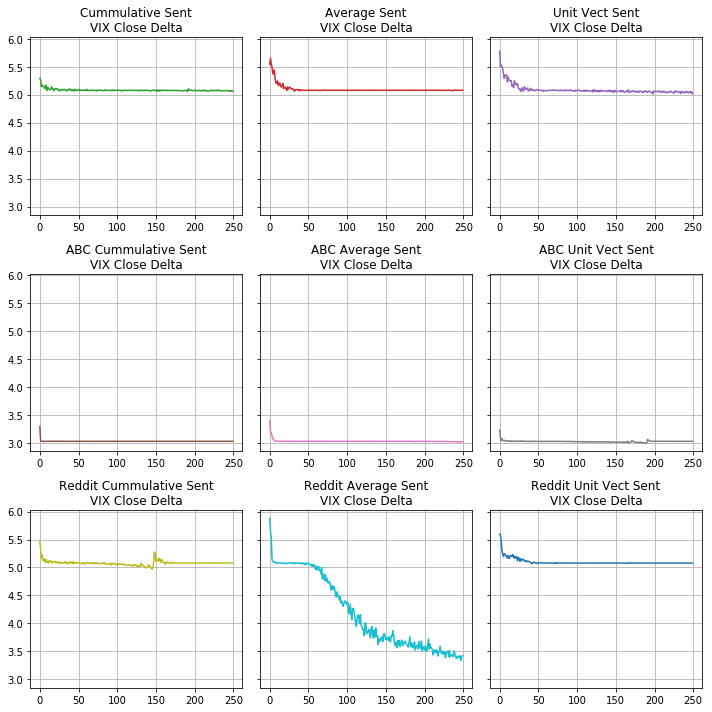

In [240]:
ROWS = 3
COL = 3
f, axes = plt.subplots(ROWS,COL,sharey=True)
f.set_size_inches(10,10)
axes = axes.flatten()

for k,_title in enumerate(narrowed):
    axes[k].plot(narrowed_dict[_title].history['loss'],color=next(COLORS)[1])
    axes[k].set_title(_title)
    axes[k].grid()
plt.tight_layout()

<img src='saves\narrowed_field2.png'>
From the extended training, the individually scored data sets seem to work the best.  The cummulative sentiment metric is the most stable and the unit vector metric has the lower average loss but is noisy.  The average sentiment metric is somewhere in between.

We will focus on training the network on the 3 metrics with the ABC and Reddit datasets appended together,and then evaluating the results.


In [217]:
'''Create Appended Dataset'''
def combine(x1,x2):
        s0 = x1.shape[0] + x2.shape[0]
        s1 = x1.shape[1]
        s2 = x1.shape[2]
        return np.append(x1,x2).reshape(s0,s1,s2)

X_train_cumm = combine(x_pipes[0].fit_transform(train_data_sets[1]['ABC Cummulative Sent']),
                       x_pipes[0].fit_transform(train_data_sets[2]['Reddit Cummulative Sent']))
X_train_avg = combine(x_pipes[1].fit_transform(train_data_sets[1]['ABC Average Sent']),
                         x_pipes[1].fit_transform(train_data_sets[2]['Reddit Average Sent']))
X_train_unit =  combine(x_pipes[2].fit_transform(train_data_sets[1]['ABC Unit Vect Sent']),
                         x_pipes[2].fit_transform(train_data_sets[2]['Reddit Unit Vect Sent']))
y_train_appended =  np.append(vix_pipeline.fit_transform(train_data_sets[1]['VIX Close Delta']),
                         vix_pipeline.fit_transform(train_data_sets[2]['VIX Close Delta']))
# Build list of X data
X_train_dict = {"Combined Cummulative Sent":X_train_cumm,'Combined Average Sent':X_train_avg,
                'Combined Unit Vect Sent':X_train_unit}

# check shapes
for key_ in X_train_dict.keys():
    print('===================================')
    print(key_)
    print('Data Shape: ',X_train_dict[key_].shape)
    
print('===================================')
print('Target For Comibined:')
print('Data Shape: ',y_train_appended.shape)

Combined Cummulative Sent
Data Shape:  (4943, 20, 3)
Combined Average Sent
Data Shape:  (4943, 20, 3)
Combined Unit Vect Sent
Data Shape:  (4943, 20, 3)
Target For Comibined:
Data Shape:  (4943,)


### Try Combined Data Sets

<img src='saves\narrowed_field3.png'>
They all look similar except the unit vector is pretty noisy. Cummulative Sentiment has the lowest loss, but the unit vector sentiment looks like it might be decreasing faster. We will optimize both of those models.

#### Grid Search for Best Network Configuations

In [22]:
'''Setup Grid Search'''
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
_lstm = [True,False]
_nodes=[32,64,128,256,512]
_dropout=[0.1,0.2,0.4]
p_grid = dict(lstm=_lstm,n_nodes=_nodes,n_dropout=_dropout)

### Save Results and Recall as Needed

In [ ]:
## save the results to disk
#filename = 'saves\grid_search_cummulative_sent_r2.sav'
#save_object(grid_result,filename,save=True)

In [218]:
 
# load the results from disk
r1_result = save_object(None,'saves\grid_search_cummulative_sent_r1.sav',save=False)
r2_result = save_object(None,'saves\grid_search_cummulative_sent_r2.sav',save=False)

In [34]:
for i,result in enumerate([r1_result,r2_result]):
    print('Grid Search Result %d' % (i+1))
    print('For parameter grid: ',result.param_grid)
    print("Best: %f using %s" % (result.best_score_, result.best_params_))
    means = result.cv_results_['mean_test_score']
    stds = result.cv_results_['std_test_score']
    params = result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))

Grid Search Result 1
For parameter grid:  {'lstm': [True, False], 'n_nodes': [16, 32, 64, 128], 'n_dropout': [0.1, 0.2, 0.4, 0.6, 0.8]}
Best: -3.562566 using {'lstm': True, 'n_dropout': 0.2, 'n_nodes': 128}
-3.671059 (0.785514) with: {'lstm': True, 'n_dropout': 0.1, 'n_nodes': 16}
-3.825526 (0.937849) with: {'lstm': True, 'n_dropout': 0.1, 'n_nodes': 32}
-3.599856 (0.729872) with: {'lstm': True, 'n_dropout': 0.1, 'n_nodes': 64}
-3.565943 (0.739632) with: {'lstm': True, 'n_dropout': 0.1, 'n_nodes': 128}
-3.642780 (0.764126) with: {'lstm': True, 'n_dropout': 0.2, 'n_nodes': 16}
-3.700064 (0.797448) with: {'lstm': True, 'n_dropout': 0.2, 'n_nodes': 32}
-3.672820 (0.657442) with: {'lstm': True, 'n_dropout': 0.2, 'n_nodes': 64}
-3.562566 (0.742911) with: {'lstm': True, 'n_dropout': 0.2, 'n_nodes': 128}
-3.570340 (0.739446) with: {'lstm': True, 'n_dropout': 0.4, 'n_nodes': 16}
-3.593651 (0.720592) with: {'lstm': True, 'n_dropout': 0.4, 'n_nodes': 32}
-3.562568 (0.742918) with: {'lstm': True,

### Optimize Batch Size and Epochs

For {'lstm': True, 'n_dropout': 0.2, 'n_nodes': 128} using grid search

In [38]:
'''Setup Grid Search'''
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

_epochs = [10,100,250,500]
_batch=[16,32,64,1024,len(y_train_appended)]
p_grid = dict(batch_size=_batch, epochs=_epochs)

### Save Results and Then Print

In [223]:
# save the results to disk
#filename = 'saves\grid_search_cummulative_sent_batch_epoch.sav'
#save_object(grid_result, filename,save=True)


In [219]:
# load the results from disk
be_result = save_object(None,'saves\grid_search_cummulative_sent_batch_epoch.sav', save=False)

In [42]:
print('Grid Search Result For Batch Size and Epochs')
print('For parameter grid: ',be_result.param_grid)
print("Best: %f using %s" % (be_result.best_score_,
                             be_result.best_params_))
means = be_result.cv_results_['mean_test_score']
stds = be_result.cv_results_['std_test_score']
params = be_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Grid Search Result For Batch Size and Epochs
For parameter grid:  {'batch_size': [16, 32, 64, 1024, 4943], 'epochs': [10, 100, 250, 500]}
Best: -3.562273 using {'batch_size': 4943, 'epochs': 250}
-3.570133 (0.739789) with: {'batch_size': 16, 'epochs': 10}
-3.659366 (0.663469) with: {'batch_size': 16, 'epochs': 100}
-5.185566 (2.468477) with: {'batch_size': 16, 'epochs': 250}
-5.057755 (1.987794) with: {'batch_size': 16, 'epochs': 500}
-3.563215 (0.741696) with: {'batch_size': 32, 'epochs': 10}
-3.766917 (0.854435) with: {'batch_size': 32, 'epochs': 100}
-5.275649 (2.575036) with: {'batch_size': 32, 'epochs': 250}
-5.236448 (1.943482) with: {'batch_size': 32, 'epochs': 500}
-3.568447 (0.750888) with: {'batch_size': 64, 'epochs': 10}
-3.631967 (0.719700) with: {'batch_size': 64, 'epochs': 100}
-4.700073 (2.148809) with: {'batch_size': 64, 'epochs': 250}
-5.106555 (1.849312) with: {'batch_size': 64, 'epochs': 500}
-3.564218 (0.743160) with: {'batch_size': 1024, 'epochs': 10}
-3.564390 (0.

### Grid Search Over Learning Rate

In [45]:
'''Setup Grid Search'''
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

_learning = np.linspace(0.0001,0.01,10)
p_grid = dict(n_learning_rate=_learning)

### Save Results of Learning Rate Search and Then Print

In [51]:
import pickle
# save the results to disk
#filename = 'saves\grid_search_cummulative_sent_learning_rate.sav'
#save_object(grid_result,filename, save=True)

In [220]:
# load the results from disk
lr_result = save_object(None,'saves\grid_search_cummulative_sent_learning_rate.sav',save=False)

In [50]:
print('Grid Search Result For Batch Size and Epochs')
print('For parameter grid: ',lr_result.param_grid)
print("Best: %f using %s" % (lr_result.best_score_,
                             lr_result.best_params_))
means = lr_result.cv_results_['mean_test_score']
stds = lr_result.cv_results_['std_test_score']
params = lr_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Grid Search Result For Batch Size and Epochs
For parameter grid:  {'n_learning_rate': array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ])}
Best: -3.562628 using {'n_learning_rate': 0.0067}
-3.583443 (0.745713) with: {'n_learning_rate': 0.0001}
-3.580806 (0.742316) with: {'n_learning_rate': 0.0012000000000000001}
-3.566751 (0.744609) with: {'n_learning_rate': 0.0023}
-3.562735 (0.742851) with: {'n_learning_rate': 0.0034}
-3.563475 (0.742882) with: {'n_learning_rate': 0.0045000000000000005}
-3.563066 (0.742519) with: {'n_learning_rate': 0.005600000000000001}
-3.562628 (0.742962) with: {'n_learning_rate': 0.0067}
-3.563129 (0.742611) with: {'n_learning_rate': 0.0078000000000000005}
-3.565030 (0.745006) with: {'n_learning_rate': 0.0089}
-3.563386 (0.742529) with: {'n_learning_rate': 0.01}


### Build and Train Final Model for Testing

In [221]:
# Define Hyperparameters as found in search
OPT_NODES = 128
EPOCHS = 310 # Best is 250 but we will use early stopping
DROPOUT = 0.2
VALID_SPLIT = 0.15
BATCH = int(len(y_train_appended)*(1-VALID_SPLIT))  # Full Batch
LEARNING = 0.0067 # Best is 0.0067 but we will use Reducing On Plate

# Create Model
np.random.seed(42)
final_model = create_model(lstm=True,n_nodes=OPT_NODES,
                           n_dropout=DROPOUT,n_learning_rate=LEARNING,step_size=STEP_SIZE)
final_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               67584     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 128       
_________________________________________________________________
batch_normalization_18 (Batc (None, 1)                 4         
_________________________________________________________________
activation_18 (Activation)   (None, 1)                 0         
Total params: 67,716
Trainable params: 67,714
Non-trainable params: 2
_________________________________________________________________


In [222]:
'''Build Callbacks'''
MIN_DELTA = 0.0001
'''Decrease on plateu Callback'''
lr_dec = ReduceLROnPlateau(
    monitor='loss', factor=0.7, patience=20, verbose=1, mode='auto',
    min_delta=MIN_DELTA, cooldown=40, min_lr=0.002,
)

optimizer = Adam(learning_rate=LEARNING)

es_callback = EarlyStopping(monitor='loss', min_delta=MIN_DELTA,
                            patience=100,verbose=1, mode='min',
                            baseline=None, restore_best_weights=True)

In [137]:
# define the checkpoint

filepath = 'final_weights' + datetime.now().strftime("%Y%m%d-%H%M%S") +'.hdf5'
#filepath = os.path.join(curr_dir, 'saves',filepath)

checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# fit model
np.random.seed(42)
hist = final_model.fit(X_train_dict["Combined Cummulative Sent"],y_train_appended,
          validation_split=VALID_SPLIT,
          batch_size=BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[checkpoint])
done()

Train on 4201 samples, validate on 742 samples
Epoch 1/310
4201/4201 [==============================] - 1s 325us/step - loss: 4.3702 - accuracy: 0.0033 - val_loss: 1.2245 - val_accuracy: 0.0094

Epoch 00001: loss improved from inf to 4.37024, saving model to final_weights20200331-175739.hdf5
Epoch 2/310
4201/4201 [==============================] - 1s 244us/step - loss: 4.5354 - accuracy: 0.0050 - val_loss: 1.2237 - val_accuracy: 0.0094

Epoch 00002: loss did not improve from 4.37024
Epoch 3/310
4201/4201 [==============================] - 1s 255us/step - loss: 4.4451 - accuracy: 0.0045 - val_loss: 1.2231 - val_accuracy: 0.0094

Epoch 00003: loss did not improve from 4.37024
Epoch 4/310
4201/4201 [==============================] - 1s 253us/step - loss: 4.2544 - accuracy: 0.0024 - val_loss: 1.2236 - val_accuracy: 0.0094

Epoch 00004: loss improved from 4.37024 to 4.25438, saving model to final_weights20200331-175739.hdf5
Epoch 5/310
4201/4201 [==============================] - 1s 249us/s

4201/4201 [==============================] - 1s 282us/step - loss: 3.9864 - accuracy: 0.0048 - val_loss: 1.2230 - val_accuracy: 0.0094

Epoch 00039: loss did not improve from 3.97668
Epoch 40/310
4201/4201 [==============================] - 1s 281us/step - loss: 3.9853 - accuracy: 0.0045 - val_loss: 1.2229 - val_accuracy: 0.0094

Epoch 00040: loss did not improve from 3.97668
Epoch 41/310
4201/4201 [==============================] - 1s 282us/step - loss: 3.9914 - accuracy: 0.0048 - val_loss: 1.2227 - val_accuracy: 0.0094

Epoch 00041: loss did not improve from 3.97668
Epoch 42/310
4201/4201 [==============================] - 1s 275us/step - loss: 3.9834 - accuracy: 0.0048 - val_loss: 1.2226 - val_accuracy: 0.0094

Epoch 00042: loss did not improve from 3.97668
Epoch 43/310
4201/4201 [==============================] - 1s 270us/step - loss: 3.9837 - accuracy: 0.0048 - val_loss: 1.2225 - val_accuracy: 0.0094

Epoch 00043: loss did not improve from 3.97668
Epoch 44/310
4201/4201 [=========


Epoch 00079: loss did not improve from 3.95996
Epoch 80/310
4201/4201 [==============================] - 1s 308us/step - loss: 3.9571 - accuracy: 0.0048 - val_loss: 1.2222 - val_accuracy: 0.0094

Epoch 00080: loss improved from 3.95996 to 3.95708, saving model to final_weights20200331-175739.hdf5
Epoch 81/310
4201/4201 [==============================] - 1s 319us/step - loss: 3.9600 - accuracy: 0.0048 - val_loss: 1.2223 - val_accuracy: 0.0094

Epoch 00081: loss did not improve from 3.95708
Epoch 82/310
4201/4201 [==============================] - 1s 300us/step - loss: 3.9672 - accuracy: 0.0048 - val_loss: 1.2223 - val_accuracy: 0.0094

Epoch 00082: loss did not improve from 3.95708
Epoch 83/310
4201/4201 [==============================] - 1s 287us/step - loss: 3.9703 - accuracy: 0.0048 - val_loss: 1.2223 - val_accuracy: 0.0094

Epoch 00083: loss did not improve from 3.95708
Epoch 84/310
4201/4201 [==============================] - 1s 264us/step - loss: 3.9632 - accuracy: 0.0048 - val_l

4201/4201 [==============================] - 1s 266us/step - loss: 3.9379 - accuracy: 0.0048 - val_loss: 1.2233 - val_accuracy: 0.0094

Epoch 00119: loss did not improve from 3.93101
Epoch 120/310
4201/4201 [==============================] - 1s 279us/step - loss: 3.9340 - accuracy: 0.0048 - val_loss: 1.2231 - val_accuracy: 0.0094

Epoch 00120: loss did not improve from 3.93101
Epoch 121/310
4201/4201 [==============================] - 1s 270us/step - loss: 3.9306 - accuracy: 0.0050 - val_loss: 1.2233 - val_accuracy: 0.0094

Epoch 00121: loss improved from 3.93101 to 3.93060, saving model to final_weights20200331-175739.hdf5
Epoch 122/310
4201/4201 [==============================] - 1s 269us/step - loss: 3.9257 - accuracy: 0.0045 - val_loss: 1.2232 - val_accuracy: 0.0094

Epoch 00122: loss improved from 3.93060 to 3.92574, saving model to final_weights20200331-175739.hdf5
Epoch 123/310
4201/4201 [==============================] - 1s 280us/step - loss: 3.9594 - accuracy: 0.0052 - val_los


Epoch 00158: loss did not improve from 3.87464
Epoch 159/310
4201/4201 [==============================] - 1s 259us/step - loss: 3.9178 - accuracy: 0.0048 - val_loss: 1.2242 - val_accuracy: 0.0094

Epoch 00159: loss did not improve from 3.87464
Epoch 160/310
4201/4201 [==============================] - 1s 259us/step - loss: 3.9069 - accuracy: 0.0048 - val_loss: 1.2245 - val_accuracy: 0.0094

Epoch 00160: loss did not improve from 3.87464
Epoch 161/310
4201/4201 [==============================] - 1s 255us/step - loss: 3.8885 - accuracy: 0.0045 - val_loss: 1.2248 - val_accuracy: 0.0094

Epoch 00161: loss did not improve from 3.87464
Epoch 162/310
4201/4201 [==============================] - 1s 261us/step - loss: 3.8991 - accuracy: 0.0048 - val_loss: 1.2251 - val_accuracy: 0.0094

Epoch 00162: loss did not improve from 3.87464
Epoch 163/310
4201/4201 [==============================] - 1s 257us/step - loss: 3.8892 - accuracy: 0.0048 - val_loss: 1.2253 - val_accuracy: 0.0094

Epoch 00163: l

4201/4201 [==============================] - 1s 268us/step - loss: 3.5392 - accuracy: 0.0045 - val_loss: 1.2354 - val_accuracy: 0.0094

Epoch 00196: loss improved from 3.57029 to 3.53922, saving model to final_weights20200331-175739.hdf5
Epoch 197/310
4201/4201 [==============================] - 1s 277us/step - loss: 3.5708 - accuracy: 0.0048 - val_loss: 1.2336 - val_accuracy: 0.0094

Epoch 00197: loss did not improve from 3.53922
Epoch 198/310
4201/4201 [==============================] - 1s 270us/step - loss: 3.5418 - accuracy: 0.0048 - val_loss: 1.2332 - val_accuracy: 0.0094

Epoch 00198: loss did not improve from 3.53922
Epoch 199/310
4201/4201 [==============================] - 1s 263us/step - loss: 3.5336 - accuracy: 0.0050 - val_loss: 1.2339 - val_accuracy: 0.0094

Epoch 00199: loss improved from 3.53922 to 3.53360, saving model to final_weights20200331-175739.hdf5
Epoch 200/310
4201/4201 [==============================] - 1s 269us/step - loss: 3.5209 - accuracy: 0.0045 - val_los


Epoch 00231: loss improved from 3.18205 to 3.16491, saving model to final_weights20200331-175739.hdf5
Epoch 232/310
4201/4201 [==============================] - 1s 260us/step - loss: 3.1663 - accuracy: 0.0048 - val_loss: 1.4157 - val_accuracy: 0.0081

Epoch 00232: loss did not improve from 3.16491
Epoch 233/310
4201/4201 [==============================] - 1s 266us/step - loss: 3.1998 - accuracy: 0.0048 - val_loss: 1.3728 - val_accuracy: 0.0094

Epoch 00233: loss did not improve from 3.16491
Epoch 234/310
4201/4201 [==============================] - 1s 263us/step - loss: 3.1460 - accuracy: 0.0048 - val_loss: 1.3484 - val_accuracy: 0.0094

Epoch 00234: loss improved from 3.16491 to 3.14604, saving model to final_weights20200331-175739.hdf5
Epoch 235/310
4201/4201 [==============================] - 1s 273us/step - loss: 3.1515 - accuracy: 0.0055 - val_loss: 1.3915 - val_accuracy: 0.0094

Epoch 00235: loss did not improve from 3.14604
Epoch 236/310
4201/4201 [=============================


Epoch 00267: loss improved from 2.93714 to 2.92280, saving model to final_weights20200331-175739.hdf5
Epoch 268/310
4201/4201 [==============================] - 1s 276us/step - loss: 2.9132 - accuracy: 0.0050 - val_loss: 1.6061 - val_accuracy: 0.0081

Epoch 00268: loss improved from 2.92280 to 2.91321, saving model to final_weights20200331-175739.hdf5
Epoch 269/310
4201/4201 [==============================] - 1s 263us/step - loss: 2.9202 - accuracy: 0.0052 - val_loss: 1.8853 - val_accuracy: 0.0067

Epoch 00269: loss did not improve from 2.91321
Epoch 270/310
4201/4201 [==============================] - 1s 259us/step - loss: 2.9068 - accuracy: 0.0052 - val_loss: 1.5251 - val_accuracy: 0.0081

Epoch 00270: loss improved from 2.91321 to 2.90682, saving model to final_weights20200331-175739.hdf5
Epoch 271/310
4201/4201 [==============================] - 1s 259us/step - loss: 2.9366 - accuracy: 0.0055 - val_loss: 1.6483 - val_accuracy: 0.0067

Epoch 00271: loss did not improve from 2.90682


Epoch 00304: loss improved from 2.70803 to 2.69814, saving model to final_weights20200331-175739.hdf5
Epoch 305/310
4201/4201 [==============================] - 1s 259us/step - loss: 2.6821 - accuracy: 0.0057 - val_loss: 2.3993 - val_accuracy: 0.0094

Epoch 00305: loss improved from 2.69814 to 2.68207, saving model to final_weights20200331-175739.hdf5
Epoch 306/310
4201/4201 [==============================] - 1s 268us/step - loss: 2.6717 - accuracy: 0.0057 - val_loss: 2.4053 - val_accuracy: 0.0081

Epoch 00306: loss improved from 2.68207 to 2.67170, saving model to final_weights20200331-175739.hdf5
Epoch 307/310
4201/4201 [==============================] - 1s 268us/step - loss: 2.6616 - accuracy: 0.0052 - val_loss: 2.2780 - val_accuracy: 0.0094

Epoch 00307: loss improved from 2.67170 to 2.66162, saving model to final_weights20200331-175739.hdf5
Epoch 308/310
4201/4201 [==============================] - 1s 266us/step - loss: 2.6545 - accuracy: 0.0052 - val_loss: 2.3199 - val_accuracy:

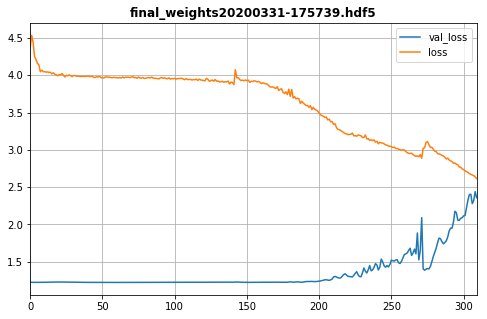

In [138]:
"""Plot learning curves"""
pd.DataFrame(hist.history)[['val_loss','loss']].plot(figsize=(8, 5))
plt.grid(True)
_=plt.title(filepath,fontweight='bold')


In [139]:
'''Save Model and Training History'''
save_object(hist,'hist_model_325epochs.sav',save=True,addTime=True)
save_object(final_model,'final_model_325epochs.sav',save=True,addTime=True)

Saved File:  hist_model_325epochs20200331-180440.sav
Saved File:  final_model_325epochs20200331-180440.sav


In [194]:
best_model = 'final_model_325epochs20200331-180440.sav'#'final_model_700epochs20200331-170746.sav'
model_best = save_object(None,best_model,save=False)
# model_best.load_weights('final_weights_overfit_20200331-143907.hdf5') # 1000 Epochs
model_best.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 128)               67584     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 128       
_________________________________________________________________
batch_normalization_16 (Batc (None, 1)                 4         
_________________________________________________________________
activation_16 (Activation)   (None, 1)                 0         
Total params: 67,716
Trainable params: 67,714
Non-trainable params: 2
_________________________________________________________________


# Score against Test Set


In [195]:
'''Format Test Set'''
X_test_abc = x_pipes[0].fit_transform(test_data_sets[1]['ABC Cummulative Sent'])
X_test_reddit = x_pipes[0].fit_transform(test_data_sets[2]['Reddit Cummulative Sent'])

y_test_abc =  vix_pipeline.fit_transform(test_data_sets[1]['VIX Close Delta'])
y_test_reddit = vix_pipeline.fit_transform(test_data_sets[2]['VIX Close Delta'])

print('X Test ABC Data: ',X_test_abc.shape)
print('y Test ABC Data: ',y_test_abc.shape)
print('X Test ABC Data: ',X_test_reddit.shape)
print('y Test ABC Data: ',y_test_reddit.shape)

X Test ABC Data:  (827, 20, 3)
y Test ABC Data:  (827,)
X Test ABC Data:  (377, 20, 3)
y Test ABC Data:  (377,)


In [196]:
from math import sqrt
from sklearn.metrics import mean_squared_error

testPredictABC = model_best.predict(X_test_abc)
# calulate RSME
testScoreABC = sqrt(mean_squared_error(y_test_abc, testPredictABC[:,0]))
print('ABC Test Score: %.2f RMSE' % (testScoreABC))

testPredictReddit = model_best.predict(X_test_reddit)
# calulate RSME
testScoreReddit = sqrt(mean_squared_error(y_test_reddit, testPredictReddit[:,0]))
print('Reddit Test Score: %.2f RMSE' % (testScoreReddit))

ABC Test Score: 1.84 RMSE
Reddit Test Score: 2.07 RMSE


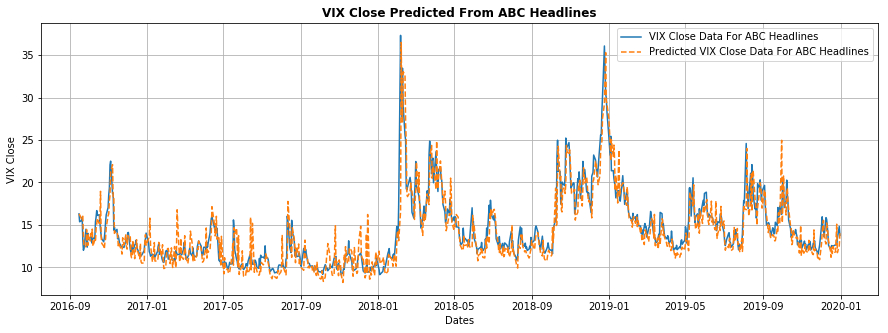

In [197]:
'''Plot Results From ABC Data'''
plt.figure(figsize=(15,5))
dates = test_data_sets[1]['VIX Close'][STEP_SIZE:].index
abc_close = test_data_sets[1]['VIX Close'][STEP_SIZE:].values
abc_pred = np.zeros_like(abc_close)
abc_pred[0] = abc_close[0]
for i in range(1,len(abc_close)):
    abc_pred[i] = abc_close[i-1] + testPredictABC[i]

plt.plot(dates,abc_close,label='VIX Close Data For ABC Headlines')
plt.plot(dates,abc_pred,'--',label='Predicted VIX Close Data For ABC Headlines')
plt.legend(loc='best')
plt.title('VIX Close Predicted From ABC Headlines',fontweight='bold')
plt.xlabel('Dates')
plt.ylabel('VIX Close')
_=plt.grid()

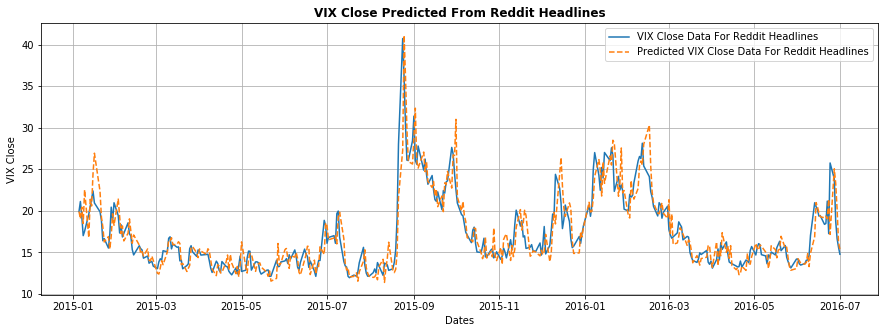

In [198]:
'''Plot Results From Reddit Data'''
plt.figure(figsize=(15,5))
dates = test_data_sets[2]['VIX Close'][STEP_SIZE:].index
reddit_close = test_data_sets[2]['VIX Close'][STEP_SIZE:].values
reddit_pred = np.zeros_like(reddit_close)
reddit_pred[0] = reddit_close[0]
for i in range(1,len(reddit_close)):
    reddit_pred[i] = reddit_close[i-1] + testPredictReddit[i]

plt.plot(dates,reddit_close,label='VIX Close Data For Reddit Headlines')
plt.plot(dates,reddit_pred,'--',label='Predicted VIX Close Data For Reddit Headlines')
plt.legend(loc='best')
plt.title('VIX Close Predicted From Reddit Headlines',fontweight='bold')
plt.xlabel('Dates')
plt.ylabel('VIX Close')
_=plt.grid()

In [226]:
OPT_NODES = 128
EPOCHS = 310 # Best is 250 but we will use early stopping
DROPOUT = 0.2
VALID_SPLIT = 0.15
BATCH = int(len(y_train_appended)*(1-VALID_SPLIT))  # Full Batch
LEARNING = 0.0067 # Best is 0.0067 but we will use Reducing On Plate

_optimizer = Adam(learning_rate=0.0067)
model3 = Sequential()
model3.add(LSTM(128,input_shape=(20,3)))
model3.add(Dropout(0.2))
model3.add(Dense(64,activation='elu',kernel_initializer='he_normal',use_bias=False))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(1,activation='elu',kernel_initializer='he_normal',use_bias=False))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.compile(loss='mean_squared_error', optimizer=_optimizer,metrics=['accuracy'])

In [228]:
# define the checkpoint

filepath = 'extra_layer' + datetime.now().strftime("%Y%m%d-%H%M%S") +'.hdf5'
#filepath = os.path.join(curr_dir, 'saves',filepath)

checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# fit model
np.random.seed(42)
hist3 = model3.fit(X_train_dict["Combined Cummulative Sent"],y_train_appended,
          validation_split=VALID_SPLIT,
          batch_size=BATCH,
          epochs=EPOCHS,
          verbose=1,
          callbacks=[checkpoint])
done()

Train on 4201 samples, validate on 742 samples
Epoch 1/310
4201/4201 [==============================] - 2s 503us/step - loss: 4.7763 - accuracy: 0.0040 - val_loss: 1.2656 - val_accuracy: 0.0094

Epoch 00001: loss improved from inf to 4.77633, saving model to extra_layer20200404-135342.hdf5
Epoch 2/310
4201/4201 [==============================] - 1s 293us/step - loss: 4.7857 - accuracy: 0.0026 - val_loss: 1.3134 - val_accuracy: 0.0094

Epoch 00002: loss did not improve from 4.77633
Epoch 3/310
4201/4201 [==============================] - 1s 313us/step - loss: 4.7268 - accuracy: 0.0021 - val_loss: 1.3259 - val_accuracy: 0.0094

Epoch 00003: loss improved from 4.77633 to 4.72681, saving model to extra_layer20200404-135342.hdf5
Epoch 4/310
4201/4201 [==============================] - 1s 312us/step - loss: 4.6817 - accuracy: 0.0026 - val_loss: 1.3306 - val_accuracy: 0.0094

Epoch 00004: loss improved from 4.72681 to 4.68167, saving model to extra_layer20200404-135342.hdf5
Epoch 5/310
4201/4


Epoch 00037: loss did not improve from 4.09597
Epoch 38/310
4201/4201 [==============================] - 1s 321us/step - loss: 4.1154 - accuracy: 0.0043 - val_loss: 3.0282 - val_accuracy: 0.0013

Epoch 00038: loss did not improve from 4.09597
Epoch 39/310
4201/4201 [==============================] - 1s 325us/step - loss: 4.1412 - accuracy: 0.0040 - val_loss: 2.7290 - val_accuracy: 0.0000e+00

Epoch 00039: loss did not improve from 4.09597
Epoch 40/310
4201/4201 [==============================] - 1s 336us/step - loss: 4.1764 - accuracy: 0.0040 - val_loss: 2.4848 - val_accuracy: 0.0000e+00

Epoch 00040: loss did not improve from 4.09597
Epoch 41/310
4201/4201 [==============================] - 1s 344us/step - loss: 4.1892 - accuracy: 0.0043 - val_loss: 2.3561 - val_accuracy: 0.0000e+00

Epoch 00041: loss did not improve from 4.09597
Epoch 42/310
4201/4201 [==============================] - 1s 327us/step - loss: 4.1845 - accuracy: 0.0043 - val_loss: 2.2381 - val_accuracy: 0.0000e+00

Epo

4201/4201 [==============================] - 1s 328us/step - loss: 4.0334 - accuracy: 0.0048 - val_loss: 1.4212 - val_accuracy: 0.0094

Epoch 00078: loss did not improve from 4.03183
Epoch 79/310
4201/4201 [==============================] - 1s 324us/step - loss: 4.0202 - accuracy: 0.0048 - val_loss: 1.4116 - val_accuracy: 0.0094

Epoch 00079: loss improved from 4.03183 to 4.02022, saving model to extra_layer20200404-135342.hdf5
Epoch 80/310
4201/4201 [==============================] - 1s 343us/step - loss: 4.0384 - accuracy: 0.0045 - val_loss: 1.4035 - val_accuracy: 0.0094

Epoch 00080: loss did not improve from 4.02022
Epoch 81/310
4201/4201 [==============================] - 1s 332us/step - loss: 4.0690 - accuracy: 0.0045 - val_loss: 1.3819 - val_accuracy: 0.0094

Epoch 00081: loss did not improve from 4.02022
Epoch 82/310
4201/4201 [==============================] - 1s 332us/step - loss: 4.0590 - accuracy: 0.0040 - val_loss: 1.3694 - val_accuracy: 0.0094

Epoch 00082: loss did not i

4201/4201 [==============================] - 1s 310us/step - loss: 4.0260 - accuracy: 0.0045 - val_loss: 1.2298 - val_accuracy: 0.0094

Epoch 00118: loss did not improve from 3.99773
Epoch 119/310
4201/4201 [==============================] - 1s 306us/step - loss: 4.0142 - accuracy: 0.0045 - val_loss: 1.2313 - val_accuracy: 0.0094

Epoch 00119: loss did not improve from 3.99773
Epoch 120/310
4201/4201 [==============================] - 1s 309us/step - loss: 4.0308 - accuracy: 0.0045 - val_loss: 1.2332 - val_accuracy: 0.0094

Epoch 00120: loss did not improve from 3.99773
Epoch 121/310
4201/4201 [==============================] - 1s 299us/step - loss: 4.0395 - accuracy: 0.0045 - val_loss: 1.2344 - val_accuracy: 0.0094

Epoch 00121: loss did not improve from 3.99773
Epoch 122/310
4201/4201 [==============================] - 1s 307us/step - loss: 4.0126 - accuracy: 0.0045 - val_loss: 1.2375 - val_accuracy: 0.0094

Epoch 00122: loss did not improve from 3.99773
Epoch 123/310
4201/4201 [====


Epoch 00158: loss improved from 3.97635 to 3.96882, saving model to extra_layer20200404-135342.hdf5
Epoch 159/310
4201/4201 [==============================] - 1s 305us/step - loss: 3.9598 - accuracy: 0.0043 - val_loss: 1.3702 - val_accuracy: 0.0081

Epoch 00159: loss improved from 3.96882 to 3.95980, saving model to extra_layer20200404-135342.hdf5
Epoch 160/310
4201/4201 [==============================] - 1s 291us/step - loss: 3.9661 - accuracy: 0.0045 - val_loss: 1.3783 - val_accuracy: 0.0081

Epoch 00160: loss did not improve from 3.95980
Epoch 161/310
4201/4201 [==============================] - 1s 297us/step - loss: 3.9782 - accuracy: 0.0045 - val_loss: 1.3838 - val_accuracy: 0.0081

Epoch 00161: loss did not improve from 3.95980
Epoch 162/310
4201/4201 [==============================] - 1s 288us/step - loss: 3.9470 - accuracy: 0.0045 - val_loss: 1.3830 - val_accuracy: 0.0081

Epoch 00162: loss improved from 3.95980 to 3.94700, saving model to extra_layer20200404-135342.hdf5
Epoch


Epoch 00199: loss did not improve from 3.94700
Epoch 200/310
4201/4201 [==============================] - 1s 285us/step - loss: 4.1028 - accuracy: 0.0038 - val_loss: 1.5422 - val_accuracy: 0.0067

Epoch 00200: loss did not improve from 3.94700
Epoch 201/310
4201/4201 [==============================] - 1s 285us/step - loss: 4.0982 - accuracy: 0.0040 - val_loss: 1.5284 - val_accuracy: 0.0081

Epoch 00201: loss did not improve from 3.94700
Epoch 202/310
4201/4201 [==============================] - 1s 286us/step - loss: 4.0866 - accuracy: 0.0040 - val_loss: 1.5234 - val_accuracy: 0.0081

Epoch 00202: loss did not improve from 3.94700
Epoch 203/310
4201/4201 [==============================] - 1s 285us/step - loss: 4.0835 - accuracy: 0.0040 - val_loss: 1.5138 - val_accuracy: 0.0081

Epoch 00203: loss did not improve from 3.94700
Epoch 204/310
4201/4201 [==============================] - 1s 287us/step - loss: 4.0722 - accuracy: 0.0040 - val_loss: 1.5061 - val_accuracy: 0.0081

Epoch 00204: l


Epoch 00241: loss did not improve from 3.94700
Epoch 242/310
4201/4201 [==============================] - 1s 322us/step - loss: 3.9988 - accuracy: 0.0048 - val_loss: 1.3111 - val_accuracy: 0.0094

Epoch 00242: loss did not improve from 3.94700
Epoch 243/310
4201/4201 [==============================] - 1s 350us/step - loss: 3.9991 - accuracy: 0.0048 - val_loss: 1.3076 - val_accuracy: 0.0094

Epoch 00243: loss did not improve from 3.94700
Epoch 244/310
4201/4201 [==============================] - 2s 372us/step - loss: 3.9902 - accuracy: 0.0048 - val_loss: 1.3056 - val_accuracy: 0.0094

Epoch 00244: loss did not improve from 3.94700
Epoch 245/310
4201/4201 [==============================] - 2s 382us/step - loss: 3.9942 - accuracy: 0.0048 - val_loss: 1.3018 - val_accuracy: 0.0094

Epoch 00245: loss did not improve from 3.94700
Epoch 246/310
4201/4201 [==============================] - 1s 347us/step - loss: 3.9935 - accuracy: 0.0048 - val_loss: 1.2977 - val_accuracy: 0.0094

Epoch 00246: l


Epoch 00283: loss did not improve from 3.94700
Epoch 284/310
4201/4201 [==============================] - 1s 289us/step - loss: 3.9577 - accuracy: 0.0048 - val_loss: 1.2512 - val_accuracy: 0.0081

Epoch 00284: loss did not improve from 3.94700
Epoch 285/310
4201/4201 [==============================] - 1s 302us/step - loss: 3.9585 - accuracy: 0.0048 - val_loss: 1.2488 - val_accuracy: 0.0081

Epoch 00285: loss did not improve from 3.94700
Epoch 286/310
4201/4201 [==============================] - 1s 297us/step - loss: 3.9590 - accuracy: 0.0048 - val_loss: 1.2500 - val_accuracy: 0.0081

Epoch 00286: loss did not improve from 3.94700
Epoch 287/310
4201/4201 [==============================] - 1s 285us/step - loss: 3.9547 - accuracy: 0.0048 - val_loss: 1.2496 - val_accuracy: 0.0081

Epoch 00287: loss did not improve from 3.94700
Epoch 288/310
4201/4201 [==============================] - 1s 293us/step - loss: 3.9570 - accuracy: 0.0048 - val_loss: 1.2461 - val_accuracy: 0.0081

Epoch 00288: l

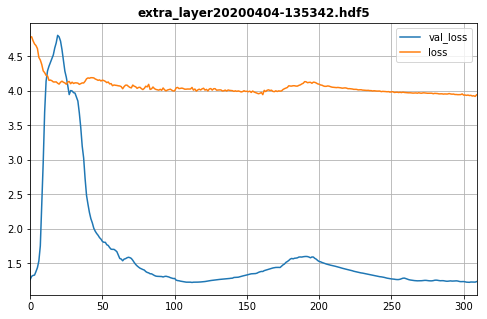

In [229]:
"""Plot learning curves"""
pd.DataFrame(hist3.history)[['val_loss','loss']].plot(figsize=(8, 5))
plt.grid(True)
_=plt.title(filepath,fontweight='bold')

In [ ]:
Teh 